In [1]:
import pandas as pd
filtered_df = pd.read_csv('study2_responses.csv')

In [3]:
import statsmodels.formula.api as smf
target_vals = [
 'rightorwrong','repair_score',
 'return_likelihood',
 'response_quality',
 'performance_trust_score',
 'moral_trust_score',]
for dv in target_vals:
    print(f"\n### {dv} ###")
    try:
        tdf = filtered_df.dropna(subset=[dv,'scenarioNum'])  # include necessary vars
        print(len(tdf))
        model = smf.ols(f"{dv} ~ is_syco * is_anthro", data=tdf).fit()

        print(model.summary())
#         print("p-value for AIAS_comp:", model.pvalues.get("AIAS_comp", "N/A"))
    except Exception as e:
        print("Error fitting model:", e)



### rightorwrong ###
804
                            OLS Regression Results                            
Dep. Variable:           rightorwrong   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     106.5
Date:                Thu, 18 Sep 2025   Prob (F-statistic):           5.19e-58
Time:                        11:12:34   Log-Likelihood:                -1525.6
No. Observations:                 804   AIC:                             3059.
Df Residuals:                     800   BIC:                             3078.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

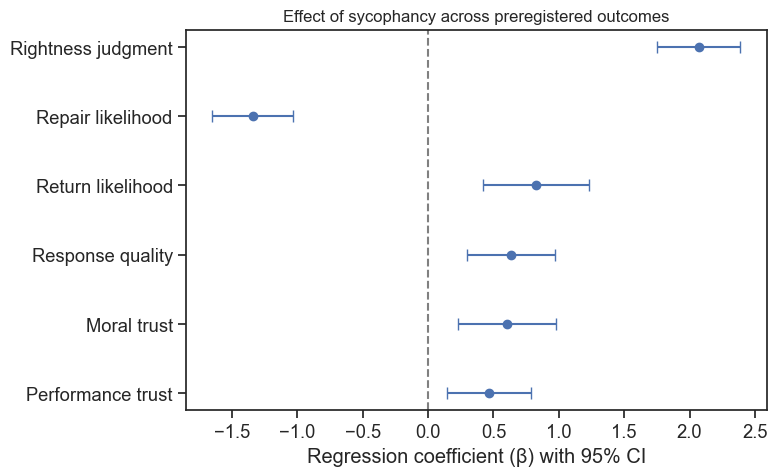

Saved: forest_syco_main_effects.png, interaction_<dv>.png, plus CSVs.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import sem, t

import seaborn as sns
sns.set_context("paper")
sns.set(font_scale = 1.2)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 1.2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

def apply_style(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for yy in np.arange(0.2,1,0.1): # change to wherever you want dashed lines
        ax.axhline(y=yy, linestyle='--', color='black', linewidth=1, alpha=0.3)
    
# ============================================
# Results figures directly from your OLS fits
# filtered_df must exist with columns:
#   - is_syco, is_anthro  (bool or 0/1)
#   - each DV in target_vals
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# ----------------------------
# User inputs
# ----------------------------
# Example:
# target_vals = [
#     "repair_likelihood", "return_likelihood", "response_quality",
#     "rightness_judgment", "performance_trust", "moral_trust_score"
# ]
# Choose which DVs to make interaction plots for:
interaction_dvs = ["return_likelihood", "moral_trust_score",'response_quality']  # adjust as needed

# ----------------------------
# Clean coding of factors
# ----------------------------
df = filtered_df.copy()
# Coerce booleans to 0/1 if needed (robust to already-int columns)
for col in ["is_syco", "is_anthro"]:
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)
    else:
        # if stored as strings like "True"/"False"
        if df[col].dtype == object:
            df[col] = df[col].astype(str).str.lower().map({"true":1,"false":0}).fillna(df[col]).astype(int)

# ----------------------------
# Fit OLS models (preregistered)
# DV ~ is_syco * is_anthro
# ----------------------------
models = {}
for dv in target_vals:
    tdf = df.dropna(subset=[dv, "is_syco", "is_anthro"])
    if len(tdf) == 0:
        print(f"[WARN] No rows after dropna for {dv}")
        continue
    try:
        model = smf.ols(f"{dv} ~ is_syco * is_anthro", data=tdf).fit()
        models[dv] = model
    except Exception as e:
        print(f"[ERR] Fitting {dv} failed: {e}")

# ----------------------------
# Helper: pull a parameter by name even if encoded oddly
# (handles 'is_syco' vs 'is_syco[T.True]'-style names)
# ----------------------------
def find_param_like(result, key_fragment):
    names = result.params.index.tolist()
    for nm in names:
        if key_fragment in nm:
            return nm
    return None

# ----------------------------
# Build forest-plot dataframe for sycophancy main effects
# ----------------------------
rows = []
for dv, m in models.items():
    p = find_param_like(m, "is_syco")
    if p is None:
        print(f"[WARN] Couldn't find sycophancy param in {dv}")
        continue
    beta = m.params[p]
    se   = m.bse[p]
    ci   = m.conf_int().loc[p].tolist()  # [low, high]
    rows.append({"dv": dv, "beta": beta, "se": se, "ci_low": ci[0], "ci_high": ci[1]})

forest_df = pd.DataFrame(rows)
if forest_df.empty:
    raise RuntimeError("No sycophancy effects found; check column names and model fits.")

# Nice labels (optional)
label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}
forest_df["dv_label"] = forest_df["dv"].map(label_map).fillna(forest_df["dv"])

# ----------------------------
# Forest plot
# ----------------------------
def plot_forest(df, title="Effect of sycophancy across preregistered outcomes",
                outfile="forest_syco_main_effects.png", show=True):
    d = df.copy()
    d["abs_beta"] = d["beta"].abs()
    d = d.sort_values("abs_beta", ascending=True)

    y = np.arange(len(d))
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.errorbar(
        d["beta"], y,
        xerr=[d["beta"] - d["ci_low"], d["ci_high"] - d["beta"]],
        fmt='o', capsize=4
    )
    ax.axvline(0, linestyle='--', color='grey')
    ax.set_yticks(y)
    ax.set_yticklabels(d["dv_label"])
    ax.set_xlabel("Regression coefficient (β) with 95% CI")
    ax.set_title(title, fontsize=12)
    fig.tight_layout()
    fig.savefig(outfile, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)

plot_forest(forest_df)

# ----------------------------
# Estimated Marginal Means (EMMs) for 2×2 grid
# ----------------------------
def emmeans_2x2(model, dv_name):
    """
    Returns a dataframe with means and 95% CI for the 4 cells:
    (is_syco in {0,1}) × (is_anthro in {0,1})
    Uses model.get_prediction with a new exog DataFrame (same column names).
    """
    grid = pd.DataFrame({
        "is_syco":   [0, 0, 1, 1],
        "is_anthro": [0, 1, 0, 1],
    })
    # model was fit with formula; pass same-named columns
    pr = model.get_prediction(grid)
    summ = pr.summary_frame(alpha=0.05)  # mean, mean_ci_lower, mean_ci_upper, etc.
    out = grid.copy()
    out["mean"]   = summ["mean"].values
    out["ci_low"] = summ["mean_ci_lower"].values
    out["ci_high"]= summ["mean_ci_upper"].values
    out["dv"]     = dv_name
    # Pretty labels
    out["sycophancy"]      = out["is_syco"].map({0:"Non-sycophantic", 1:"Sycophantic"})
    out["anthropomorphism"]= out["is_anthro"].map({0:"Non-anthro", 1:"Anthro"})
    return out[["dv","sycophancy","anthropomorphism","mean","ci_low","ci_high"]]

# Build one big EMMs table (handy to save or reuse)
emm_list = []
for dv, m in models.items():
    try:
        emm = emmeans_2x2(m, dv)
        emm_list.append(emm)
    except Exception as e:
        print(f"[WARN] EMMs failed for {dv}: {e}")
emm_df = pd.concat(emm_list, ignore_index=True)

# ----------------------------
# 2×2 interaction plot helper
# ----------------------------
def plot_interaction(emm_df, dv, ylabel=None, title=None,
                     outfile=None, show=True):
    df2 = emm_df[emm_df["dv"] == dv].copy()
    if df2.empty:
        print(f"[WARN] No EMMs for DV '{dv}'.")
        return
    df2["sycophancy"] = pd.Categorical(df2["sycophancy"],
                                       categories=["Non-sycophantic", "Sycophantic"],
                                       ordered=True)
    df2["anthropomorphism"] = pd.Categorical(df2["anthropomorphism"],
                                             categories=["Non-anthro", "Anthro"],
                                             ordered=True)
    df2 = df2.sort_values(["sycophancy","anthropomorphism"])

    x_levels = df2["sycophancy"].cat.categories.tolist()
    x = np.arange(len(x_levels))
    def pick(level):
        d = df2[df2["anthropomorphism"] == level]
        return d["mean"].to_numpy(), d["ci_low"].to_numpy(), d["ci_high"].to_numpy()

    means_non, lows_non, highs_non = pick("Non-anthro")
    means_ant, lows_ant, highs_ant = pick("Anthro")

    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(x, means_non, marker='o', label="Non-anthro")
    ax.errorbar(x, means_non, yerr=[means_non - lows_non, highs_non - means_non],
                fmt='o', capsize=4)

    ax.plot(x, means_ant, marker='o', label="Anthro")
    ax.errorbar(x, means_ant, yerr=[means_ant - lows_ant, highs_ant - means_ant],
                fmt='o', capsize=4)

    ax.set_xticks(x)
    ax.set_xticklabels(x_levels)
    ax.set_ylabel(ylabel or dv)
    ax.set_title(title or f"Sycophancy × Anthropomorphism on {dv}")
    ax.legend()
    fig.tight_layout()
    if outfile:
        fig.savefig(outfile, dpi=300, bbox_inches="tight")
    if show:
        plt.show()
    plt.close(fig)


# Optional: save the derived tables
forest_df.to_csv("syco_main_effects_from_models.csv", index=False)
emm_df.to_csv("emmeans_2x2_from_models.csv", index=False)

print("Saved: forest_syco_main_effects.png, interaction_<dv>.png, plus CSVs.")



In [6]:

import pandas as pd
import numpy as np

# Pretty labels (edit as needed)
DV_LABEL = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}
TERM_ORDER = ["is_syco", "is_anthro", "is_syco:is_anthro"]
TERM_LABEL = {
    "is_syco": "Sycophancy",
    "is_anthro": "Anthropomorphism",
    "is_syco:is_anthro": "Interaction",
}

def starify(p):
    if p < 0.001: return "***"
    if p < 0.01:  return "**"
    if p < 0.05:  return "*"
    return ""

def fmt_beta_ci(beta, lo, hi, p, digits=2):
    return f"{beta:.{digits}f} [{lo:.{digits}f}, {hi:.{digits}f}]{starify(p)}"

# ------------ Collect rows ------------
rows_full = []
rows_compact = []
for dv, m in models.items():
    for term in TERM_ORDER:
        pname = find_param_like(m, term)
        if pname is None or pname not in m.params.index:
            continue
        beta = float(m.params[pname])
        se   = float(m.bse[pname])
        ci_lo, ci_hi = m.conf_int().loc[pname]
        pval = float(m.pvalues[pname])

        # long (full) row
        rows_full.append({
            "DV": DV_LABEL.get(dv, dv),
            "Term": TERM_LABEL.get(term, term),
            "β": round(beta, 3),
            "SE": round(se, 3),
            "CI_low": round(ci_lo, 3),
            "CI_high": round(ci_hi, 3),
            "p": round(pval, 4),
            "stars": starify(pval),
        })

        # compact cell string β [lo, hi] + stars
        rows_compact.append({
            "Term": TERM_LABEL.get(term, term),
            "DV": DV_LABEL.get(dv, dv),
            "β [95% CI]": fmt_beta_ci(beta, ci_lo, ci_hi, pval, digits=2),
        })

full_df = pd.DataFrame(rows_full)
compact_long = pd.DataFrame(rows_compact)

# ------------ Wide compact table (main text) ------------
compact_wide = (compact_long
                .pivot(index="Term", columns="DV", values="β [95% CI]")
                .reindex(index=[TERM_LABEL[t] for t in TERM_ORDER if TERM_LABEL.get(t) in set(compact_long["Term"])])
                .sort_index(axis=1))  # alphabetical DV columns; change if you want a custom order

# Optional: custom DV column order
desired_order = ["Repair likelihood", "Return likelihood", "Response quality",
                 "Rightness judgment", "Performance trust", "Moral trust"]
compact_wide = compact_wide.reindex(columns=[c for c in desired_order if c in compact_wide.columns])

# ------------ Save outputs ------------
full_df.to_csv("regression_full_long.csv", index=False)
compact_wide.to_csv("regression_compact_wide.csv")

# LaTeX (Nature-friendly). escape=False lets stars/brackets pass through.
latex_compact = compact_wide.to_latex(escape=False, na_rep="–",
                                      column_format="l" + "c"*compact_wide.shape[1],
                                      caption="Regression estimates for preregistered model DV ~ Sycophancy × Anthropomorphism. Cells show β [95% CI]. Stars: * p<.05, ** p<.01, *** p<.001.",
                                      label="tab:regression_compact")
with open("regression_compact_wide.tex", "w") as f:
    f.write(latex_compact)

latex_full = full_df[["DV","Term","β","SE","CI_low","CI_high","p","stars"]].to_latex(
    index=False, escape=False, na_rep="–",
    caption="Full regression results for DV ~ Sycophancy × Anthropomorphism.",
    label="tab:regression_full"
)
with open("regression_full_long.tex", "w") as f:
    f.write(latex_full)

print("Saved tables:\n - regression_compact_wide.csv / .tex\n - regression_full_long.csv / .tex")


Saved tables:
 - regression_compact_wide.csv / .tex
 - regression_full_long.csv / .tex


In [7]:
compact_wide

DV,Repair likelihood,Return likelihood,Response quality,Rightness judgment,Performance trust,Moral trust
Term,,,,,,
Sycophancy,"-1.34 [-1.65, -1.03]***","0.83 [0.42, 1.23]***","0.64 [0.30, 0.97]***","2.07 [1.75, 2.39]***","0.47 [0.14, 0.79]**","0.61 [0.23, 0.98]**"
Anthropomorphism,"0.12 [-0.18, 0.43]","0.23 [-0.17, 0.63]","0.26 [-0.07, 0.59]","0.15 [-0.16, 0.47]","0.16 [-0.16, 0.48]","0.41 [0.04, 0.78]*"
Interaction,"-0.21 [-0.65, 0.22]","-0.57 [-1.14, -0.00]*","-0.42 [-0.90, 0.05]","-0.07 [-0.51, 0.38]","-0.38 [-0.84, 0.07]","-0.63 [-1.16, -0.10]*"


In [8]:
aias_cols = ['AIAS_1', 'AIAS_2', 'AIAS_3', 'AIAS_4']  # update with your actual column names
filtered_df['AIAS_comp'] = filtered_df[aias_cols].mean(axis=1)


In [9]:
filtered_df.is_syco.value_counts()

is_syco
False    408
True     396
Name: count, dtype: int64

In [10]:
filtered_df.is_anthro.value_counts()

is_anthro
True     406
False    398
Name: count, dtype: int64

In [33]:
filtered_df.groupby(['is_syco','is_anthro','scenarioNum']).size()


is_syco  is_anthro  scenarioNum
False    False      1              53
                    2              51
                    3              49
                    4              46
         True       1              50
                    2              48
                    3              51
                    4              53
True     False      1              51
                    2              47
                    3              52
                    4              46
         True       1              50
                    2              52
                    3              48
                    4              48
dtype: int64

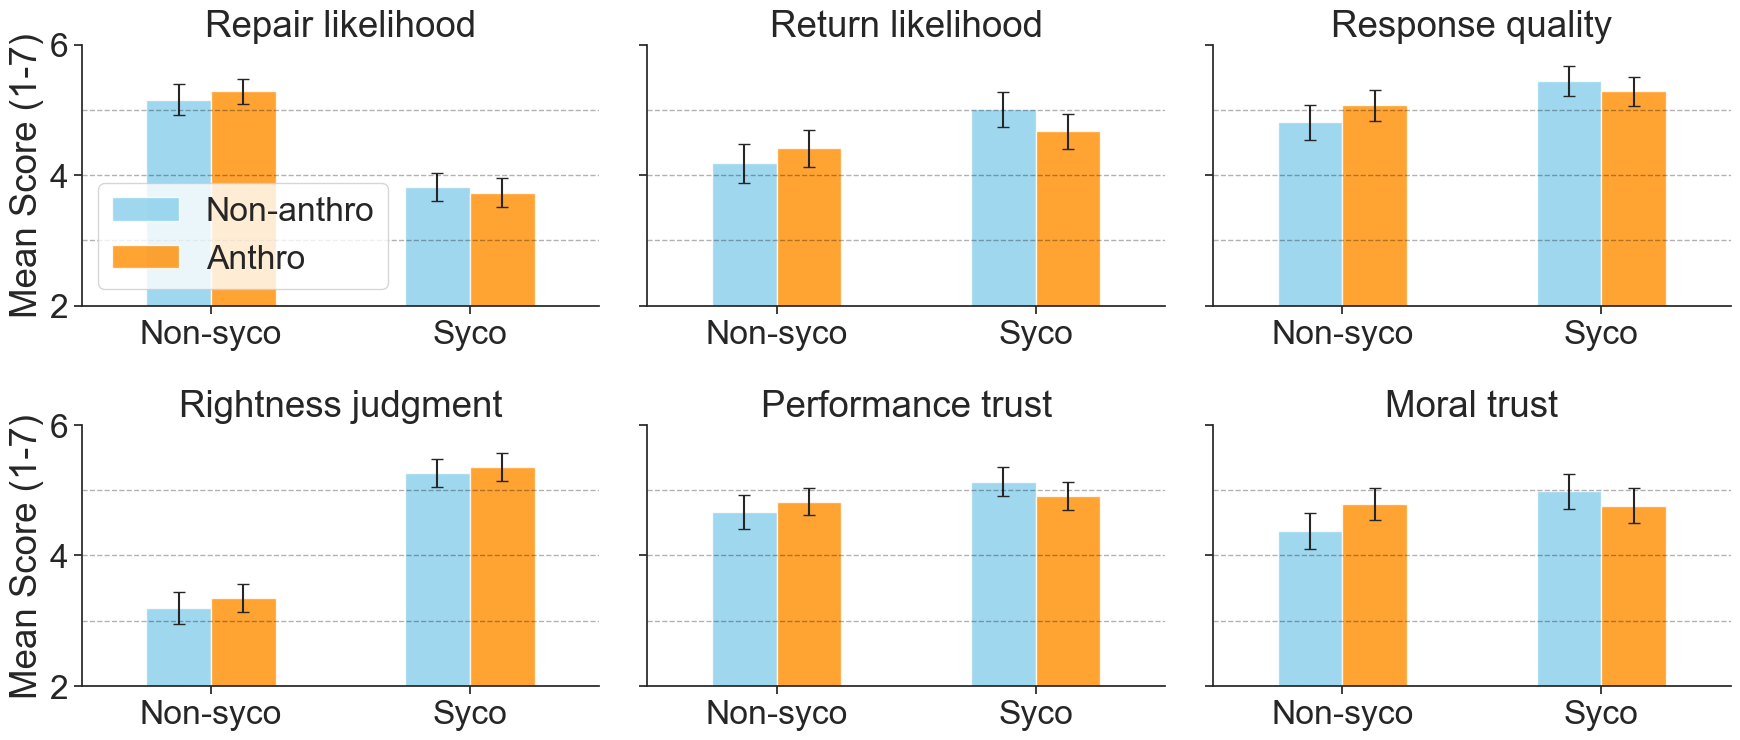

In [11]:
from scipy.stats import sem
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set_context("paper")
sns.set(font_scale=2.2)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2.2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

def apply_style(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for yy in np.arange(2,6,1): # change to wherever you want dashed lines
        ax.axhline(y=yy, linestyle='--', color='black', linewidth=1, alpha=0.3)
    
# Determine grid size
num_vars = len(target_vals)
cols = 3
rows = math.ceil(num_vars / cols)

# Set up subplots
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows),sharey=True)
axes = axes.flatten()  # Make axes iterable

label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}

for i, t in enumerate([
    'repair_score',
    'return_likelihood',
    'response_quality',
    'rightorwrong',
    'performance_trust_score',
    'moral_trust_score',
]):
    # Drop NaNs
    df_plot = filtered_df.dropna(subset=[t, 'is_syco', 'is_anthro'])

    # Group by is_syco and is_anthro
    grouped = df_plot.groupby(['is_syco', 'is_anthro'])[t]

    # Compute mean and standard error
    means = grouped.mean().unstack()
    errors = grouped.apply(sem).unstack()

    # Plot
    ax = axes[i]
    means.plot.bar(
        yerr=1.96 * errors,
        capsize=4,
        ax=ax,
        alpha=0.8,
        color=["skyblue", "darkorange"]  # anthro colors
    )
    ax.set_title(label_map[t])
    ax.set_ylabel("Mean Score (1-7)")
    ax.set_xticks([0, 1], ['Non-syco', 'Syco'], rotation=0)
    ax.set_xlabel('')
    ax.set_ylim([2, 6])

    # Remove legends for all but the first plot
    if i != 0:
        ax.get_legend().remove()
    else:
        ax.legend(labels=["Non-anthro", "Anthro"],ncol=1)
    apply_style(ax)
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


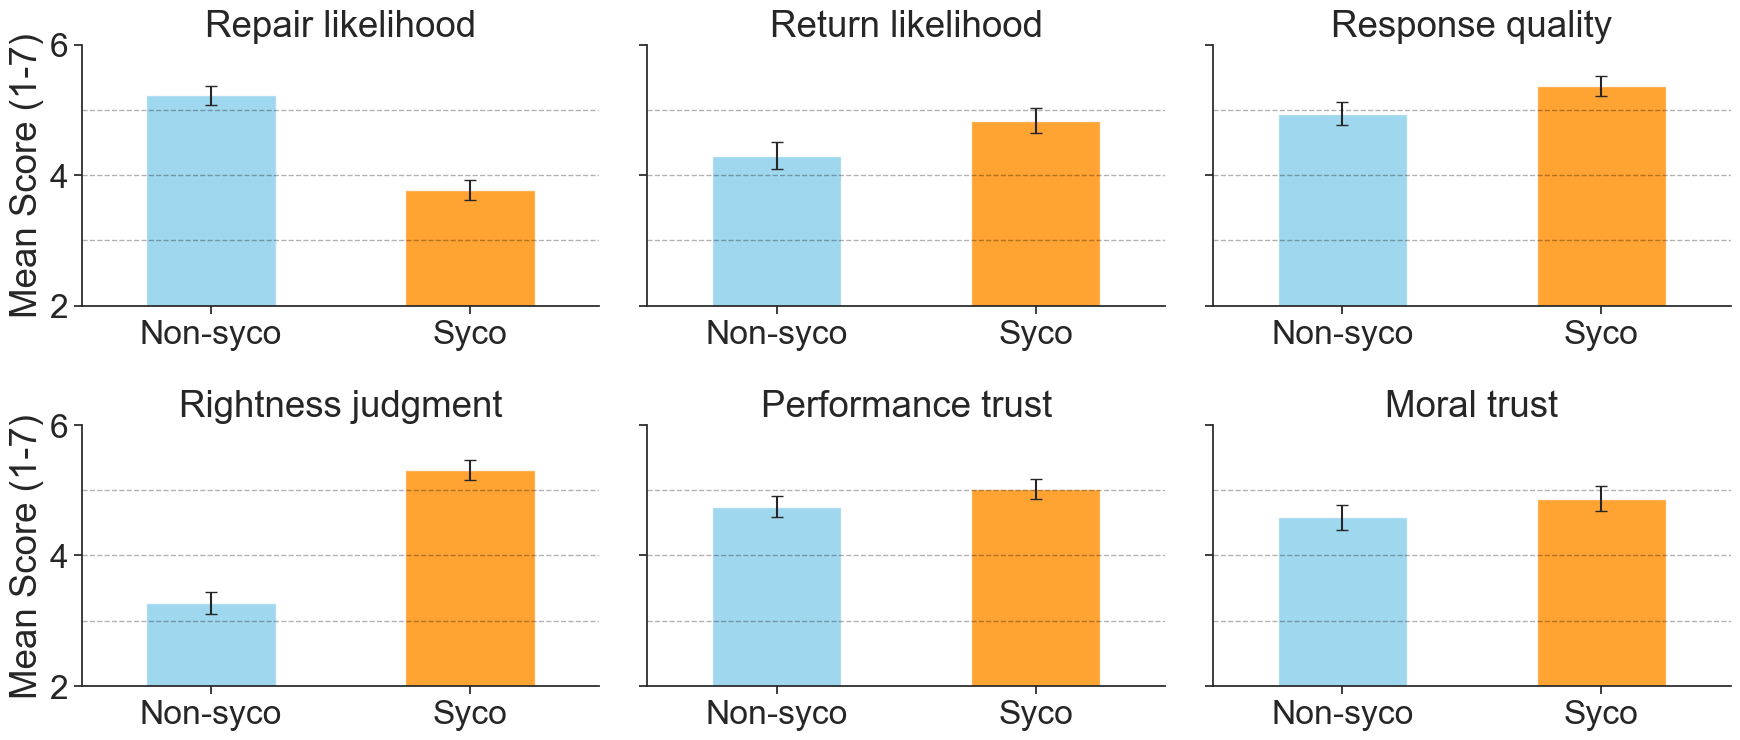

In [12]:
from scipy.stats import sem
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

sns.set_context("paper")
sns.set(font_scale=2.2)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2.2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

def apply_style(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for yy in np.arange(2,6,1): # dashed reference grid
        ax.axhline(y=yy, linestyle='--', color='black', linewidth=1, alpha=0.3)
    
# Determine grid size
num_vars = len(target_vals)
cols = 3
rows = math.ceil(num_vars / cols)

# Set up subplots
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), sharey=True)
axes = axes.flatten()

label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}

for i, t in enumerate([
    'repair_score',
    'return_likelihood',
    'response_quality',
    'rightorwrong',
    'performance_trust_score',
    'moral_trust_score',
]):
    # Drop NaNs
    df_plot = filtered_df.dropna(subset=[t, 'is_syco'])

    # Group by is_syco only
    grouped = df_plot.groupby('is_syco')[t]

    # Compute mean and standard error
    means = grouped.mean()
    errors = grouped.apply(sem)

    # Plot
    ax = axes[i]
    means.plot.bar(
        yerr=1.96 * errors,
        capsize=4,
        ax=ax,
        alpha=0.8,
        color=["skyblue", "darkorange"]
    )
    ax.set_title(label_map[t])
    ax.set_ylabel("Mean Score (1-7)")
    ax.set_xticks([0, 1], ['Non-syco', 'Syco'], rotation=0)
    ax.set_xlabel('')
    ax.set_ylim([2, 6])

#     ax.get_legend().remove()  # no legend needed
    apply_style(ax)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [14]:
filtered_df['heard_of_num'] = filtered_df['Q97'].str.count(',') + 1


In [15]:
filtered_df['used_num'] = filtered_df['used'].str.count(',') + 1


In [16]:
# Mapping dictionary
likert_map = {
    "Disagree strongly": -2,
    "Disagree a little": -1,
    "Neither agree nor disagree": 0,
    "Agree a little": 1,
    "Agree strongly": 2
}

# Identify all relevant columns
big_five_cols = [col for col in filtered_df.columns if col.startswith("big_five_")]

# Apply the mapping to each column
for col in big_five_cols:
    filtered_df[col + "_num"] = filtered_df[col].map(likert_map)
    
    # Step 2: Traits mapping
trait_map = {
    "big_five_1": ("Extraversion", True),      # reverse-coded
    "big_five_2": ("Agreeableness", False),
    "big_five_3": ("Conscientiousness", True), # reverse-coded
    "big_five_4": ("Neuroticism", True),       # reverse-coded
    "big_five_5": ("Openness", True),          # reverse-coded
    "big_five_6": ("Extraversion", False),
    "big_five_7": ("Agreeableness", True),     # reverse-coded
    "big_five_8": ("Conscientiousness", False),
    "big_five_9": ("Neuroticism", False),
    "big_five_10": ("Openness", False)
}

# Step 3: Map text responses to numeric values
for col in trait_map:
    filtered_df[col + "_num"] = filtered_df[col].map(likert_map)

# Step 4: Reverse-code relevant items
for col, (_, reverse) in trait_map.items():
    num_col = col + "_num"
    if reverse:
        filtered_df[num_col] = filtered_df[num_col] * -1

# Step 5: Optional — calculate average for each Big Five trait
traits = ["Extraversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness"]
for trait in traits:
    trait_cols = [col + "_num" for col, (t, _) in trait_map.items() if t == trait]
    filtered_df[f"{trait}_avg"] = filtered_df[trait_cols].mean(axis=1)


In [17]:
filtered_df['age'].mean()

37.88930348258707

In [18]:
import pandas as pd

# split on commas, stack into one column, strip spaces
race_counts = (
    filtered_df['race']
    .dropna()
    .str.split(",")
    .explode()
    .str.strip()
    .value_counts()
)

print(race_counts)


race
White or Caucasian                                  601
Black or African American                           121
Asian                                                87
Other                                                25
American Indian/Native American or Alaska Native     17
Prefer not to say                                     5
Native Hawaiian or Other Pacific Islander             4
Name: count, dtype: int64


In [19]:
filtered_df['gender'].value_counts()

gender
Female                       434
Male                         356
Non-binary / third gender     10
Prefer not to say              4
Name: count, dtype: int64

In [20]:
import statsmodels.formula.api as smf

for dv in target_vals:
    print(dv)
    try:
        tdf = filtered_df.dropna(subset=[dv])  # include necessary vars
        model = smf.ols(
            f"""{dv} ~ 
                is_syco * is_anthro + heard_of_num + used_num + Extraversion_avg +
                Agreeableness_avg +
                 Conscientiousness_avg +
               Neuroticism_avg +
                Openness_avg +
                AIAS_comp + age
            """,
            data=tdf
        ).fit()
    
        summary_df = pd.concat([
            model.params,
            model.pvalues,
            model.conf_int()
        ], axis=1)
        summary_df.columns = ['coef', 'pval', 'ci_lower', 'ci_upper']

        print(summary_df[summary_df['pval'] < 0.05])
        
#         print(summary_df[summary_df['pval'] < 0.05])
#         if model.pvalues.get(var)< 0.1 or model.pvalues.get(f'Condition[T.syco]:{var}')< 0.1 :
#             print(f"\n### {dv} ###")
#                 print(i)
#                 print(model.pvalues.get(var))
#                 print('------')
#         print(model.summary())
#             print("p-value for AIAS_comp:", model.pvalues.get("AIAS_comp", "N/A"))
    except Exception as e:
        print("Error fitting model:", e)


rightorwrong
                     coef          pval  ci_lower  ci_upper
Intercept        3.515509  1.023658e-27  2.907963  4.123055
is_syco[T.True]  2.098274  9.054529e-34  1.774701  2.421848
Neuroticism_avg -0.146166  1.317690e-02 -0.261643 -0.030689
age             -0.012443  7.344232e-03 -0.021531 -0.003356
repair_score
                       coef          pval  ci_lower  ci_upper
Intercept          4.598134  7.574766e-47  4.012790  5.183479
is_syco[T.True]   -1.412754  4.222909e-18 -1.724503 -1.101005
Agreeableness_avg  0.154712  1.048943e-02  0.036335  0.273090
Neuroticism_avg    0.141135  1.297713e-02  0.029878  0.252392
return_likelihood
                                       coef          pval  ci_lower  ci_upper
Intercept                          1.425099  3.819481e-05  0.749793  2.100404
is_syco[T.True]                    0.758712  3.844702e-05  0.399050  1.118373
is_anthro[T.True]                  0.379917  3.900158e-02  0.019230  0.740604
is_syco[T.True]:is_anthro[T.True] 

In [21]:
import re
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# --- 1) Normalize gender ---
def normalize_gender(x: str):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    s = re.sub(r'[^a-z ]+', '', s)  # remove punctuation
    if any(k in s for k in ["female", "woman", "girl", "fem"]):
        return "female"
    if any(k in s for k in ["male", "man", "boy", "masc"]):
        return "male"
    if any(k in s for k in ["nonbinary", "non binary", "nb", "enby", "genderqueer", "agender"]):
        return "nonbinary"
    return np.nan

filtered_df = filtered_df.copy()
filtered_df["gender_norm"] = filtered_df["gender"].map(normalize_gender)

filtered_df["gender_cat"] = pd.Categorical(
    filtered_df["gender_norm"],
    categories=["female", "male", "nonbinary"],
    ordered=False
)

# --- 2) Normalize race ---
def normalize_race(x: str):
    if pd.isna(x):
        return np.nan
    parts = [p.strip() for p in str(x).split(",")]
    # if multiple, just keep first listed for regression (simplify)
    primary = parts[0]
    return primary

filtered_df["race_norm"] = filtered_df["race"].map(normalize_race)

# Choose a reference category (most frequent = White or Caucasian)
ref_race = "White or Caucasian"
categories = [
    ref_race,
    "Black or African American",
    "Asian",
    "American Indian/Native American or Alaska Native",
    "Native Hawaiian or Other Pacific Islander",
    "Other",
    "Prefer not to say"
]

filtered_df["race_cat"] = pd.Categorical(
    filtered_df["race_norm"],
    categories=categories,
    ordered=False
)

print("Gender counts:\n", filtered_df["gender_cat"].value_counts(dropna=False))
print("\nRace counts:\n", filtered_df["race_cat"].value_counts(dropna=False))
# Normalize frequency into ordered categories
freq_order = [
    "Never",
    "Once every few months",
    "A few times a month",
    "A few times a week",
    "Daily"
]

filtered_df["frequency_cat"] = pd.Categorical(
    filtered_df["frequency"].str.strip(),
    categories=freq_order,
    ordered=True
)

print(filtered_df["frequency_cat"].value_counts(dropna=False))

# --- 3) Regression with gender + race ---
for dv in target_vals:
    print("\n==========", dv, "==========")
    try:
        needed_cols = [
            dv, "is_syco", "is_anthro", "heard_of_num", "used_num",
            "Extraversion_avg", "Agreeableness_avg", "Conscientiousness_avg",
            "Neuroticism_avg", "Openness_avg", "AIAS_comp", "age",
            "gender_cat", "race_cat"
        ]
        tdf = filtered_df.dropna(subset=needed_cols)

        model = smf.ols(
            f"""{dv} ~ 
                 is_syco * is_anthro + heard_of_num + used_num +
                 Extraversion_avg + Agreeableness_avg + Conscientiousness_avg +
                 Neuroticism_avg + Openness_avg + AIAS_comp + age +
                 C(gender_cat, Treatment('female')) +
                 C(race_cat, Treatment('{ref_race}'))
            """,
            data=tdf
        ).fit(cov_type="HC3")

        summary_df = pd.concat(
            [model.params, model.pvalues, model.conf_int()],
            axis=1
        )
        summary_df.columns = ['coef', 'pval', 'ci_lower', 'ci_upper']

        print("\n-- p < .05 terms --")
        print(summary_df[summary_df['pval'] < 0.05])

    except Exception as e:
        print("Error fitting model:", e)


Gender counts:
 gender_cat
female       434
male         356
nonbinary     10
NaN            4
Name: count, dtype: int64

Race counts:
 race_cat
White or Caucasian                                  601
Black or African American                           108
Asian                                                71
Other                                                12
American Indian/Native American or Alaska Native      7
Prefer not to say                                     5
Native Hawaiian or Other Pacific Islander             0
Name: count, dtype: int64
frequency_cat
A few times a week       287
Daily                    219
A few times a month      152
Once every few months     98
Never                     48
Name: count, dtype: int64

========== rightorwrong ==========

-- p < .05 terms --
                                                     coef          pval  \
Intercept                                        3.535817  6.252339e-27   
is_syco[T.True]                              

In [22]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

# Helper: format coefficient ± SE with stars
def format_coef(row):
    coef, se, p = row["coef"], row["se"], row["pval"]
    stars = ""
    if p < 0.001:
        stars = "***"
    elif p < 0.01:
        stars = "**"
    elif p < 0.05:
        stars = "*"
    return f"{coef:.3f}{stars}  \\newline ({se:.3f})"

results = {}
# ---- variable name mapping ----
var_labels = {
    "Intercept": "Intercept",
    'C(scenarioNum)[T.2]':'Scenario 2',
    'C(scenarioNum)[T.3]':'Scenario 3',
    'C(scenarioNum)[T.4]':'Scenario 4',
    "is_syco[T.True]": "Sycophancy",
    "is_anthro[T.True]": "Anthropomorphism",
    "is_syco[T.True]:is_anthro[T.True]": "Syco × Anthro",
    "heard_of_num": "Heard of AI (num)",
    "used_num": "Used AI (num)",
    "Extraversion_avg": "Extraversion",
    "Agreeableness_avg": "Agreeableness",
    "Conscientiousness_avg": "Conscientiousness",
    "Neuroticism_avg": "Neuroticism",
    "Openness_avg": "Openness",
    "AIAS_comp": "AI Attitudes",
#     frequency_cat[T.A few times a month]
    "frequency_cat[T.Once every few months]": "Freq: Few months",
    "frequency_cat[T.A few times a month]": "Freq: Few/month",
    "frequency_cat[T.A few times a week]": "Freq: Few/week",
    "frequency_cat[T.Daily]": "Freq: Daily",
    "age": "Age",
    "C(gender_cat, Treatment('female'))[T.male]": "Male",
    "C(gender_cat, Treatment('female'))[T.nonbinary]": "Nonbinary",
    "C(race_cat, Treatment('White or Caucasian'))[T.Black or African American]": "Black",
    "C(race_cat, Treatment('White or Caucasian'))[T.Asian]": "Asian",
    "C(race_cat, Treatment('White or Caucasian'))[T.American Indian/Native American or Alaska Native]": "Native American",
    "C(race_cat, Treatment('White or Caucasian'))[T.Native Hawaiian or Other Pacific Islander]": "NH/PI",
    "C(race_cat, Treatment('White or Caucasian'))[T.Other]": "Other race",
    "C(race_cat, Treatment('White or Caucasian'))[T.Prefer not to say]": "Prefer not say",
    
}



label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}

for dv in target_vals:
    try:
        needed_cols = [
            dv, "is_syco", "is_anthro", "heard_of_num", "used_num",
            "Extraversion_avg", "Agreeableness_avg", "Conscientiousness_avg",
            "Neuroticism_avg", "Openness_avg", "AIAS_comp", "age",
            "gender_cat", "race_cat",'frequency_cat'
        ]
        tdf = filtered_df.dropna(subset=needed_cols)

        model = smf.ols(
            f"""{dv} ~ 
                 is_syco * is_anthro + heard_of_num + used_num +
                 Extraversion_avg + Agreeableness_avg + Conscientiousness_avg +
                 Neuroticism_avg + Openness_avg + AIAS_comp + age + frequency_cat + 
                 C(gender_cat, Treatment('female')) +
                 C(race_cat, Treatment('White or Caucasian'))
            """,
            data=tdf
        ).fit(cov_type="HC3")

        summary_df = pd.concat(
            [model.params, model.bse, model.pvalues],
            axis=1
        )
        summary_df.columns = ['coef', 'se', 'pval']

        results[label_map[dv]] = summary_df

    except Exception as e:
        print(f"Error fitting {dv}:", e)


# --- Build LaTeX table ---
# Row index: all predictors across models

# ---- build LaTeX table ----
all_vars = sorted(set().union(*[df.index for df in results.values()]))
rows = []
for var in all_vars:
    label = var_labels.get(var, var)  # shorten name if mapping exists
    row = [label]
    for dv in target_vals:
        if var in results[label_map[dv]].index:
            row.append(format_coef(results[label_map[dv]].loc[var]))
        else:
            row.append("")
    rows.append(row)

latex = "\\begin{table}[ht]\n\\centering\n"
latex += "\\begin{tabular}{l" + "c" * len(target_vals) + "}\n"
latex += "\\hline\n"
latex += " & " + " & ".join([label_map[dv] for dv in target_vals]) + " \\\\\n"
latex += "\\hline\n"

for r in rows:
    latex += " & ".join(r) + " \\\\\n"

latex += "\\hline\n"
latex += "\\end{tabular}\n"
latex += "\\caption{OLS regression results with robust SEs. Coefficients with SEs in parentheses. * p<0.05, ** p<0.01, *** p<0.001.}\n"
latex += "\\label{tab:regressionvignette}\n"
latex += "\\end{table}"

print(latex)


\begin{table}[ht]
\centering
\begin{tabular}{lcccccc}
\hline
 & Rightness judgment & Repair likelihood & Return likelihood & Response quality & Performance trust & Moral trust \\
\hline
AI Attitudes & 0.028  \newline (0.039) & -0.018  \newline (0.037) & 0.459***  \newline (0.041) & 0.347***  \newline (0.037) & 0.314***  \newline (0.036) & 0.365***  \newline (0.043) \\
Agreeableness & -0.002  \newline (0.068) & 0.156*  \newline (0.067) & 0.163*  \newline (0.073) & 0.154*  \newline (0.067) & 0.206***  \newline (0.062) & 0.218**  \newline (0.072) \\
Male & 0.048  \newline (0.123) & -0.095  \newline (0.119) & -0.439**  \newline (0.139) & -0.306*  \newline (0.120) & -0.359**  \newline (0.111) & -0.433***  \newline (0.131) \\
Nonbinary & 0.935*  \newline (0.393) & -1.134  \newline (0.597) & 0.441  \newline (0.617) & 0.732  \newline (0.471) & 0.506  \newline (0.475) & 0.469  \newline (0.597) \\
Native American & -0.690  \newline (0.665) & 0.290  \newline (0.748) & -0.152  \newline (1.115) & 0

# Full regression

In [40]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

# Helper: format coefficient ± SE with stars
def format_coef(row):
    coef, se, p = row["coef"], row["se"], row["pval"]
    stars = ""
    if p < 0.001:
        stars = "***"
    elif p < 0.01:
        stars = "**"
    elif p < 0.05:
        stars = "*"
    return f"{coef:.3f}{stars}  \\newline ({se:.3f})"

results = {}
# ---- variable name mapping ----
var_labels = {
    "Intercept": "Intercept",
    'C(scenarioNum)[T.2]':'Scenario 2',
    'C(scenarioNum)[T.3]':'Scenario 3',
    'C(scenarioNum)[T.4]':'Scenario 4',
    "is_syco[T.True]": "Sycophancy",
    "is_anthro[T.True]": "Anthropomorphism",
    "is_syco[T.True]:is_anthro[T.True]": "Syco × Anthro",
    "heard_of_num": "Heard of AI (num)",
    "used_num": "Used AI (num)",
    "Extraversion_avg": "Extraversion",
    "Agreeableness_avg": "Agreeableness",
    "Conscientiousness_avg": "Conscientiousness",
    "Neuroticism_avg": "Neuroticism",
    "Openness_avg": "Openness",
    "AIAS_comp": "AI Attitudes",
#     frequency_cat[T.A few times a month]
    "frequency_cat[T.Once every few months]": "Freq: Few months",
    "frequency_cat[T.A few times a month]": "Freq: Few/month",
    "frequency_cat[T.A few times a week]": "Freq: Few/week",
    "frequency_cat[T.Daily]": "Freq: Daily",
    "age": "Age",
    "C(gender_cat, Treatment('female'))[T.male]": "Male",
    "C(gender_cat, Treatment('female'))[T.nonbinary]": "Nonbinary",
    "C(race_cat, Treatment('White or Caucasian'))[T.Black or African American]": "Black",
    "C(race_cat, Treatment('White or Caucasian'))[T.Asian]": "Asian",
    "C(race_cat, Treatment('White or Caucasian'))[T.American Indian/Native American or Alaska Native]": "Native American",
    "C(race_cat, Treatment('White or Caucasian'))[T.Native Hawaiian or Other Pacific Islander]": "NH/PI",
    "C(race_cat, Treatment('White or Caucasian'))[T.Other]": "Other race",
    "C(race_cat, Treatment('White or Caucasian'))[T.Prefer not to say]": "Prefer not say",
    
}



label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}

for dv in target_vals:
    try:
        needed_cols = [
            dv, "is_syco", "is_anthro", "heard_of_num", "used_num",
            "Extraversion_avg", "Agreeableness_avg", "Conscientiousness_avg",
            "Neuroticism_avg", "Openness_avg", "AIAS_comp", "age",
            "gender_cat", "race_cat",'frequency_cat','scenarioNum'
        ]
        tdf = filtered_df.dropna(subset=needed_cols)

        model = smf.ols(
            f"""{dv} ~ 
                 is_syco * is_anthro + heard_of_num + used_num +
                 Extraversion_avg + Agreeableness_avg + Conscientiousness_avg +
                 Neuroticism_avg + Openness_avg + AIAS_comp + age + frequency_cat + 
                 C(gender_cat, Treatment('female')) +
                 C(race_cat, Treatment('White or Caucasian')) + C(scenarioNum)
            """,
            data=tdf
        ).fit(cov_type="HC3")

        summary_df = pd.concat(
            [model.params, model.bse, model.pvalues],
            axis=1
        )
        summary_df.columns = ['coef', 'se', 'pval']

        results[label_map[dv]] = summary_df

    except Exception as e:
        print(f"Error fitting {dv}:", e)


# --- Build LaTeX table ---
# Row index: all predictors across models

# ---- build LaTeX table ----
all_vars = sorted(set().union(*[df.index for df in results.values()]))
rows = []
for var in all_vars:
    label = var_labels.get(var, var)  # shorten name if mapping exists
    row = [label]
    for dv in target_vals:
        if var in results[label_map[dv]].index:
            row.append(format_coef(results[label_map[dv]].loc[var]))
        else:
            row.append("")
    rows.append(row)

latex = "\\begin{table}[ht]\n\\centering\n"
latex += "\\begin{tabular}{l" + "c" * len(target_vals) + "}\n"
latex += "\\hline\n"
latex += " & " + " & ".join([label_map[dv] for dv in target_vals]) + " \\\\\n"
latex += "\\hline\n"

for r in rows:
    latex += " & ".join(r) + " \\\\\n"

latex += "\\hline\n"
latex += "\\end{tabular}\n"
latex += "\\caption{OLS regression results with robust SEs. Coefficients with SEs in parentheses. * p<0.05, ** p<0.01, *** p<0.001.}\n"
latex += "\\label{tab:regressionvignette}\n"
latex += "\\end{table}"

print(latex)



\begin{table}[ht]
\centering
\begin{tabular}{lcccccc}
\hline
 & Repair likelihood & Return likelihood & Response quality & Rightness judgment & Performance trust & Moral trust \\
\hline
AI Attitudes & -0.018  \newline (0.037) & 0.458***  \newline (0.041) & 0.346***  \newline (0.038) & 0.040  \newline (0.039) & 0.310***  \newline (0.037) & 0.360***  \newline (0.043) \\
Agreeableness & 0.156*  \newline (0.067) & 0.161*  \newline (0.073) & 0.153*  \newline (0.068) & 0.004  \newline (0.068) & 0.206**  \newline (0.063) & 0.214**  \newline (0.073) \\
Male & -0.095  \newline (0.119) & -0.439**  \newline (0.140) & -0.308*  \newline (0.120) & 0.034  \newline (0.123) & -0.359**  \newline (0.111) & -0.433***  \newline (0.131) \\
Nonbinary & -1.127  \newline (0.607) & 0.437  \newline (0.625) & 0.710  \newline (0.469) & 0.845  \newline (0.449) & 0.496  \newline (0.472) & 0.457  \newline (0.616) \\
Native American & 0.252  \newline (0.752) & -0.050  \newline (1.122) & 0.936  \newline (0.506) & -0.58

# MODERATORS

In [23]:
for dv in target_vals:
    try:
        needed_cols = [
            dv, "is_syco", "is_anthro", "heard_of_num", "used_num",
            "Extraversion_avg", "Agreeableness_avg", "Conscientiousness_avg",
            "Neuroticism_avg", "Openness_avg", "AIAS_comp", "age",
            "gender_cat", "race_cat", "frequency_cat"
        ]
        tdf = filtered_df.dropna(subset=needed_cols)

        # moderators + interactions
        moderators = [
            "is_anthro", "heard_of_num", "used_num",
            "Extraversion_avg", "Agreeableness_avg", "Conscientiousness_avg",
            "Neuroticism_avg", "Openness_avg", "AIAS_comp", "age", "frequency_cat",
            "C(gender_cat, Treatment('female'))",
            "C(race_cat, Treatment('White or Caucasian'))"
        ]
        interaction_terms = [f"is_syco:{m}" for m in moderators]

        formula = f"""{dv} ~ is_syco + {' + '.join(moderators)} + {' + '.join(interaction_terms)}"""

        model = smf.ols(formula, data=tdf).fit(cov_type="HC3")

        summary_df = pd.concat(
            [model.params, model.bse, model.pvalues],
            axis=1
        )
        summary_df.columns = ['coef', 'se', 'pval']

        results[label_map[dv]] = summary_df

    except Exception as e:
        print(f"Error fitting {dv}:", e)


In [24]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# -------------------- CONFIG --------------------
CENTER_CONTINUOUS = True

continuous_mods = [
    "heard_of_num", "used_num",
    "Extraversion_avg", "Agreeableness_avg", "Conscientiousness_avg",
    "Neuroticism_avg", "Openness_avg", "AIAS_comp", "age"
]
categorical_mods = ["is_anthro", "frequency_cat", "gender_cat", "race_cat"]

gender_baseline = "female"
race_baseline   = "White or Caucasian"

# Assumed provided by you:
# target_vals = [...]     # list of DV column names
# label_map = {...}       # dict DV -> pretty label (or use DV if missing)
# filtered_df = ...       # your DataFrame

# -------------------- PREP --------------------
work_df = filtered_df.copy()

# Make numeric 0/1 treatment variable for robust interactions
# Handles bool, 'True'/'False', or 0/1 gracefully
work_df["is_syco_num"] = work_df["is_syco"].astype(int)

# Optional: also make numeric version for is_anthro to avoid categorical naming quirks
if pd.api.types.is_bool_dtype(work_df["is_anthro"]) or work_df["is_anthro"].dropna().isin([0,1,True,False]).all():
    work_df["is_anthro_num"] = work_df["is_anthro"].astype(int)
    anthro_name = "is_anthro_num"
else:
    anthro_name = "is_anthro"

# Center continuous moderators
def center_inplace(df, cols):
    for c in cols:
        if c in df.columns:
            df[c + "_c"] = df[c] - df[c].mean()

if CENTER_CONTINUOUS:
    center_inplace(work_df, continuous_mods)
    cont_use = [c + "_c" for c in continuous_mods]
else:
    cont_use = continuous_mods

# Moderators used in interactions
moderators_for_interactions = (
    [anthro_name] +
    cont_use +
    ["C(frequency_cat)", f"C(gender_cat, Treatment('{gender_baseline}'))",
     f"C(race_cat, Treatment('{race_baseline}'))"]
)

# Main effects block
main_effects = (
    ["is_syco_num", anthro_name] +
    cont_use +
    ["C(frequency_cat)",
     f"C(gender_cat, Treatment('{gender_baseline}'))",
     f"C(race_cat, Treatment('{race_baseline}'))"]
)

def build_interactions(treat, moderators):
    # ":" = interaction only (we already include main effects)
    return [f"{treat}:{m}" for m in moderators]

def fit_and_extract(work_df, dv, label):
    # Drop NA only on columns actually used
    needed = [dv, "is_syco_num", anthro_name, "frequency_cat", "gender_cat", "race_cat"] + cont_use
    needed = [c for c in needed if c in work_df.columns]
    tdf = work_df.dropna(subset=needed).copy()
    if tdf.empty:
        print(f"[warn] DV={label}: empty after NA-drop. Check missingness.")
        return pd.DataFrame(columns=[
            "DV","Term","β","SE","t","p","p_FDR","CI_low","CI_high","N","R2_adj","term"
        ])

    interactions = build_interactions("is_syco_num", moderators_for_interactions)
    formula = f"""{dv} ~ {' + '.join(main_effects)} + {' + '.join(interactions)}"""

    try:
        model = smf.ols(formula, data=tdf).fit(cov_type="HC3")
    except Exception as e:
        print(f"[error] DV={label}: model fit failed -> {e}")
        return pd.DataFrame(columns=[
            "DV","Term","β","SE","t","p","p_FDR","CI_low","CI_high","N","R2_adj","term"
        ])

    # Assemble parameter table
    params  = model.params.rename("β").to_frame()
    bse     = model.bse.rename("SE").to_frame()
    pvals   = model.pvalues.rename("p").to_frame()
    conf    = model.conf_int(); conf.columns = ["CI_low","CI_high"]

    out = params.join(bse).join(pvals).join(conf)
    out["t"] = out["β"] / out["SE"]
    out["term"] = out.index.astype(str)

    # Keep ONLY the is_syco interactions
    inter = out[out["term"].str.contains(r"(^is_syco_num:)|(:is_syco_num$)|(:is_syco_num:)", regex=True)].copy()
    if inter.empty:
        # Show a few terms to debug naming if needed
        print(f"[info] DV={label}: no 'is_syco_num' interactions found among {len(out)} params.")
        print("  sample terms:", out.index.tolist()[:10])
        return pd.DataFrame(columns=[
            "DV","Term","β","SE","t","p","p_FDR","CI_low","CI_high","N","R2_adj","term"
        ])

    # FDR (BH) within this DV
    reject, pval_fdr, _, _ = multipletests(inter["p"].values, method="fdr_bh")
    inter["p_FDR"] = pval_fdr

    inter["DV"] = label
    inter["N"] = model.nobs
    inter["R2_adj"] = model.rsquared_adj

    # Pretty term for display
    def pretty_term(term):
        t = term.replace("is_syco_num:", "is_syco × ")
        t = t.replace(":is_syco_num", " × is_syco")
        t = t.replace("C(frequency_cat)[T.", "frequency_cat=")
        t = t.replace(f"C(gender_cat, Treatment('{gender_baseline}'))[T.", "gender=")
        t = t.replace(f"C(race_cat, Treatment('{race_baseline}'))[T.", "race=")
        t = t.replace("]", "")
        if anthro_name != "is_anthro":  # if we used numeric alias
            t = t.replace(anthro_name, "is_anthro")
        for c in cont_use:
            base = c.replace("_c", "")
            t = t.replace(c, f"{base} (centered)")
        return t

    inter["Term"] = inter["term"].apply(pretty_term)

    # Final ordering
    inter = inter[["DV","Term","β","SE","t","p","p_FDR","CI_low","CI_high","N","R2_adj","term"]]
    inter = inter.sort_values(["DV","p_FDR","p"])
    return inter

# -------------------- RUN ACROSS DVs --------------------
all_results = []
for dv in target_vals:
    label = label_map.get(dv, dv)
    res = fit_and_extract(work_df, dv, label)
    all_results.append(res)

results_table = (pd.concat(all_results, axis=0, ignore_index=True)
                 if any(len(x) for x in all_results)
                 else pd.DataFrame(columns=["DV","Term","β","SE","t","p","p_FDR","CI_low","CI_high","N","R2_adj","term"]))

# Display nicely
pd.set_option("display.max_rows", 200)
pd.set_option("display.float_format", lambda x: f"{x:0.4f}")
print(results_table if not results_table.empty else "No is_syco × moderator interactions found across DVs.")

# Optional: save CSV
# results_table.drop(columns=["term"]).to_csv("exploratory_moderation_results.csv", index=False)
# print("Saved to exploratory_moderation_results.csv")


<ipython-input-24-f02584f63e42>:104: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  inter = out[out["term"].str.contains(r"(^is_syco_num:)|(:is_syco_num$)|(:is_syco_num:)", regex=True)].copy()
<ipython-input-24-f02584f63e42>:104: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  inter = out[out["term"].str.contains(r"(^is_syco_num:)|(:is_syco_num$)|(:is_syco_num:)", regex=True)].copy()
<ipython-input-24-f02584f63e42>:104: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  inter = out[out["term"].str.contains(r"(^is_syco_num:)|(:is_syco_num$)|(:is_syco_num:)", regex=True)].copy()
<ipython-input-24-f02584f63e42>:104: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use 

                     DV                                               Term  \
0    Rightness judgment                       is_syco × AIASomp (centered)   
1    Rightness judgment                              is_syco × gender=male   
2    Rightness judgment                      is_syco × used_num (centered)   
3    Rightness judgment         is_syco × Conscientiousness_avg (centered)   
4    Rightness judgment                   is_syco × race=Prefer not to say   
5    Rightness judgment              is_syco × Extraversion_avg (centered)   
6    Rightness judgment                               is_syco × race=Asian   
7    Rightness judgment             is_syco × Agreeableness_avg (centered)   
8    Rightness judgment                               is_syco × race=Other   
9    Rightness judgment           is_syco × race=Black or African American   
10   Rightness judgment         is_syco × frequency_cat=A few times a week   
11   Rightness judgment        is_syco × frequency_cat=A few tim

In [25]:
# Keep only significant interactions (FDR < .05)
sig_results = results_table[results_table["p_FDR"] < 0.05].copy()

if sig_results.empty:
    print("No significant is_syco × moderator interactions found.")
else:
    # Round for nice display
    disp = sig_results.copy()
    disp["β"] = disp["β"].round(3)
    disp["SE"] = disp["SE"].round(3)
    disp["t"] = disp["t"].round(2)
    disp["p"] = disp["p"].map(lambda x: f"{x:.3f}")
    disp["p_FDR"] = disp["p_FDR"].map(lambda x: f"{x:.3f}")
    disp["CI_low"] = disp["CI_low"].round(3)
    disp["CI_high"] = disp["CI_high"].round(3)

    # Select columns for table
    latex_df = disp[["DV","Term","β","SE","t","p","p_FDR","CI_low","CI_high","N","R2_adj"]]

    # Convert to LaTeX tabular
    latex_table = latex_df.to_latex(
        index=False,
        escape=False,        # keep × symbol etc.
        column_format="llrrrrrrrll",  # adjust alignment
        caption="Significant moderation effects (is_syco × moderator interactions).",
        label="tab:moderation"
    )

    print(latex_table)
    # Optional: save to .tex
    # with open("sig_moderation_results.tex", "w") as f:
    #     f.write(latex_table)


\begin{table}
\caption{Significant moderation effects (is_syco × moderator interactions).}
\label{tab:moderation}
\begin{tabular}{llrrrrrrrll}
\toprule
DV & Term & β & SE & t & p & p_FDR & CI_low & CI_high & N & R2_adj \\
\midrule
Rightness judgment & is_syco × AIASomp (centered) & 0.308000 & 0.078000 & 3.970000 & 0.000 & 0.002 & 0.156000 & 0.460000 & 764.000000 & 0.319931 \\
\bottomrule
\end{tabular}
\end{table}



In [26]:
results_table.loc[results_table['p']<0.05]

,DV,Term,β,SE,t,p,p_FDR,CI_low,CI_high,N,R2_adj,term
0,Rightness judgment,is_syco × AIASomp (centered),0.3082,0.0775,3.9742,0.0001,0.0016,0.1562,0.4601,764.0000,0.3199,is_syco_num:AIAS_comp_c
22,Repair likelihood,is_syco × gender=nonbinary,-2.6444,0.8679,-3.0467,0.0023,0.0505,-4.3455,-0.9432,764.0000,0.2103,"is_syco_num:C(gender_cat, Treatment('female'))..."
23,Repair likelihood,is_syco × AIASomp (centered),-0.2076,0.0732,-2.8346,0.0046,0.0505,-0.3511,-0.0641,764.0000,0.2103,is_syco_num:AIAS_comp_c
24,Repair likelihood,is_syco × used_num (centered),0.2940,0.1278,2.2996,0.0215,0.1575,0.0434,0.5445,764.0000,0.2103,is_syco_num:used_num_c
44,Return likelihood,is_syco × age (centered),-0.0234,0.0110,-2.1239,0.0337,0.7409,-0.0450,-0.0018,764.0000,0.2280,is_syco_num:age_c
66,Response quality,is_syco × Conscientiousness_avg (centered),0.2920,0.1483,1.9687,0.0490,0.6429,0.0013,0.5828,764.0000,0.1750,is_syco_num:Conscientiousness_avg_c
88,Performance trust,is_syco × Agreeableness_avg (centered),-0.2662,0.1244,-2.1390,0.0324,0.3905,-0.5101,-0.0223,754.0000,0.2157,is_syco_num:Agreeableness_avg_c
110,Moral trust,is_syco × age (centered),-0.0262,0.0104,-2.5242,0.0116,0.2551,-0.0466,-0.0059,750.0000,0.1989,is_syco_num:age_c


In [27]:
from scipy.stats import f_oneway, kruskal
import pandas as pd

for i, t in enumerate(['repair_score',
#  'trust_score',
 'return_likelihood',
 'response_quality',
 'rightorwrong',
 'performance_trust_score',
 'moral_trust_score',]):
    print(f"\nTesting: {t}")

    # Drop NaNs
    df_plot = filtered_df.dropna(subset=[t, 'scenarioNum'])

    # Group values by scenarioNum
    grouped_values = [group[t].values for name, group in df_plot.groupby('scenarioNum')]

    # Check normality and variance assumptions if needed — skipping here

    # One-way ANOVA
    try:
        f_stat, p_val = f_oneway(*grouped_values)
        print(f"ANOVA p-value: {p_val:.4f}")
    except Exception as e:
        print(f"ANOVA failed: {e}")

    # Kruskal-Wallis test
    try:
        h_stat, kw_p = kruskal(*grouped_values)
        print(f"Kruskal-Wallis p-value: {kw_p:.4f}")
    except Exception as e:
        print(f"Kruskal-Wallis failed: {e}")



Testing: repair_score
ANOVA p-value: 0.9891
Kruskal-Wallis p-value: 0.9547

Testing: return_likelihood
ANOVA p-value: 0.1562
Kruskal-Wallis p-value: 0.1173

Testing: response_quality
ANOVA p-value: 0.2101
Kruskal-Wallis p-value: 0.1475

Testing: rightorwrong
ANOVA p-value: 0.0098
Kruskal-Wallis p-value: 0.0100

Testing: performance_trust_score
ANOVA p-value: 0.3323
Kruskal-Wallis p-value: 0.2943

Testing: moral_trust_score
ANOVA p-value: 0.0342
Kruskal-Wallis p-value: 0.0194


In [61]:
import statsmodels.formula.api as smf
import pandas as pd

tables = {}

for dv in target_vals:
    tdf = filtered_df.dropna(subset=[dv, 'scenarioNum'])
    model = smf.ols(f"{dv} ~ is_syco * is_anthro + C(scenarioNum)", data=tdf).fit()
    tables[dv] = model

# Build a LaTeX summary table
from statsmodels.iolib.summary2 import summary_col

latex_table = summary_col(
    results=list(tables.values()),
    float_format="%.3f",
    stars=True,
    model_names=[label_map[x] for x in list(tables.keys())],
    info_dict={"N":lambda x: f"{int(x.nobs)}"}
).as_latex()


for raw, pretty in var_labels.items():
    print(raw)
    latex_table = latex_table.replace('\_','_').replace(raw, pretty)

print(latex_table)

# print(latex_table)


Intercept
C(scenarioNum)[T.2]
C(scenarioNum)[T.3]
C(scenarioNum)[T.4]
is_syco[T.True]
is_anthro[T.True]
is_syco[T.True]:is_anthro[T.True]
heard_of_num
used_num
Extraversion_avg
Agreeableness_avg
Conscientiousness_avg
Neuroticism_avg
Openness_avg
AIAS_comp
frequency_cat[T.Once every few months]
frequency_cat[T.A few times a month]
frequency_cat[T.A few times a week]
frequency_cat[T.Daily]
age
C(gender_cat, Treatment('female'))[T.male]
C(gender_cat, Treatment('female'))[T.nonbinary]
C(race_cat, Treatment('White or Caucasian'))[T.Black or African American]
C(race_cat, Treatment('White or Caucasian'))[T.Asian]
C(race_cat, Treatment('White or Caucasian'))[T.American Indian/Native American or Alaska Native]
C(race_cat, Treatment('White or Caucasian'))[T.Native Hawaiian or Other Pacific Islander]
C(race_cat, Treatment('White or Caucasian'))[T.Other]
C(race_cat, Treatment('White or Caucasian'))[T.Prefer not to say]
\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lllllll}
\hlin

In [28]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import pandas as pd

for i, t in enumerate(['repair_score',
#  'trust_score',
 'return_likelihood',
 'response_quality',
 'rightorwrong',
 'performance_trust_score',
 'moral_trust_score',]):
    print(f"\nPost-hoc for: {t}")
    df_plot = filtered_df.dropna(subset=[t, 'scenarioNum'])

    try:
        tukey = pairwise_tukeyhsd(endog=df_plot[t],
                                  groups=df_plot['scenarioNum'],
                                  alpha=0.05)
        print(tukey.summary())
    except Exception as e:
        print(f"Tukey's test failed: {e}")



Post-hoc for: repair_score
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2    0.032 0.9977  -0.413 0.4771  False
     1      3   0.0267 0.9986 -0.4133 0.4667  False
     1      4  -0.0214 0.9993  -0.467 0.4242  False
     2      3  -0.0053    1.0 -0.4498 0.4392  False
     2      4  -0.0534 0.9901 -0.5034 0.3966  False
     3      4  -0.0481 0.9925 -0.4932  0.397  False
---------------------------------------------------

Post-hoc for: return_likelihood
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -0.2461   0.63  -0.776 0.2839  False
     1      3   0.0021    1.0 -0.5219 0.5261  False
     1      4   0.2301 0.6797 -0.3006 0.7607  False
     2      3   0.2482 0.6226 -0.2812 0.7775  False
     2      4   0.4761 0.1018 -0.0598  1.012  False
   

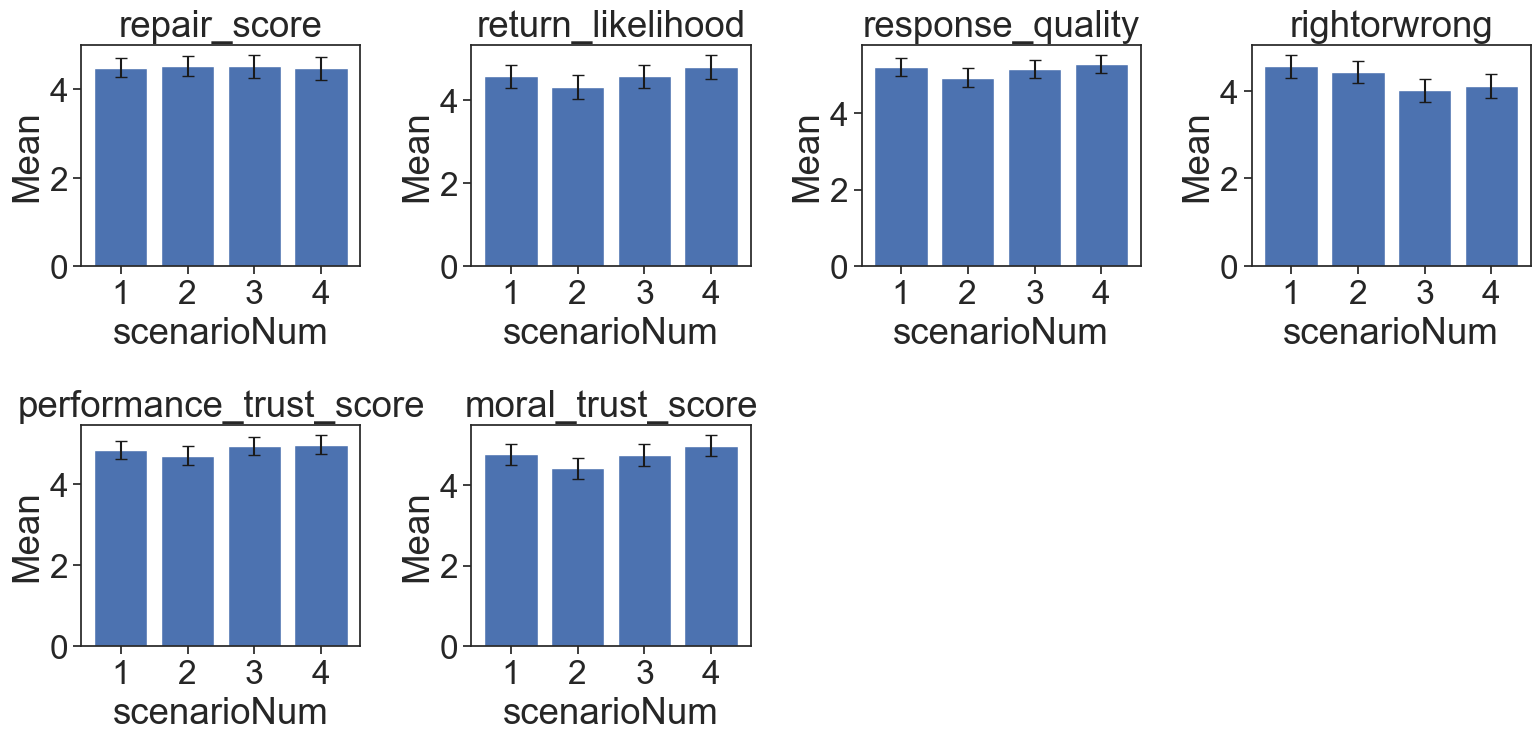

In [29]:
import matplotlib.pyplot as plt
from scipy.stats import sem
import math

# Define number of plots and layout
n_plots = len(target_vals)
n_cols = 4
n_rows = math.ceil(n_plots / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axs = axs.flatten()  # Flatten in case it's a 2D array

for i, t in enumerate(['repair_score',
#  'trust_score',
 'return_likelihood',
 'response_quality',
 'rightorwrong',
 'performance_trust_score',
 'moral_trust_score',]):
    # Drop NaNs
    df_plot = filtered_df.dropna(subset=[t, 'scenarioNum'])

    # Group by scenarioNum
    grouped = df_plot.groupby('scenarioNum')[t]

    # Compute mean and standard error
    means = grouped.mean()
    errors = grouped.apply(sem)

    # Plot on subplot
    axs[i].bar(means.index.astype(str), means.values, yerr=1.96*errors.values, capsize=4)
    axs[i].set_title(f"{t}")
    axs[i].set_xlabel("scenarioNum")
    axs[i].set_ylabel("Mean")

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [30]:
import statsmodels.formula.api as smf

# Subset your DataFrame by sycophantic condition
syco_df = filtered_df[filtered_df['is_syco'] == True]
nonsyco_df = filtered_df[filtered_df['is_syco'] == False]

# Estimate the effect of anthropomorphism within each condition
model_syco = smf.ols(f"{dv} ~ is_anthro", data=syco_df).fit()
model_nonsyco = smf.ols(f"{dv} ~ is_anthro", data=nonsyco_df).fit()

print("Sycophantic condition:")
print(model_syco.summary())

print("\nNon-sycophantic condition:")
print(model_nonsyco.summary())

Sycophantic condition:
                            OLS Regression Results                            
Dep. Variable:      moral_trust_score   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.288
Date:                Thu, 18 Sep 2025   Prob (F-statistic):              0.257
Time:                        11:18:00   Log-Likelihood:                -798.17
No. Observations:                 389   AIC:                             1600.
Df Residuals:                     387   BIC:                             1608.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept      

In [31]:
import numpy as np

# ---------- helpers ----------
def effect_and_ci(m1, s1, n1, m0, s0, n0):
    """Difference m1 - m0 with 95% CI and Cohen's d."""
    diff = m1 - m0
    se_diff = np.sqrt((s1**2)/n1 + (s0**2)/n0)
    ci = 1.96 * se_diff
    # pooled SD for Cohen's d
    denom = (n1 + n0 - 2)
    sp = np.sqrt(((n1 - 1) * (s1**2) + (n0 - 1) * (s0**2)) / denom) if denom > 0 else np.nan
    d = diff / sp if (sp is not None and sp > 0) else np.nan
    return diff, (diff - ci, diff + ci), d

def add_bracket(ax, rect_l, rect_r, text, pad_frac=0.02, tick_frac=0.01, lw=1.3, fs=11):
    """Draw a bracket between two bar Rectangles with a text label above."""
    x1 = rect_l.get_x() + rect_l.get_width() / 2
    x2 = rect_r.get_x() + rect_r.get_width() / 2
    y1 = rect_l.get_height()
    y2 = rect_r.get_height()
    y_top = max(y1, y2)

    y0, y1_lim = ax.get_ylim()
    yr = y1_lim - y0
    h = y_top + pad_frac * yr
    v = h + tick_frac * yr

    ax.plot([x1, x1, x2, x2], [h, v, v, h], c="black", lw=lw)
    ax.text((x1 + x2) / 2, v + tick_frac * yr, text, ha="center", va="bottom", fontsize=fs)

def label_n(ax, rect, n, fs=9):
    """Write n above a single bar."""
    y0, y1 = ax.get_ylim()
    yr = y1 - y0
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height() + 0.008 * yr,
        f"n={int(n)}",
        ha="center", va="bottom", fontsize=fs, color="dimgray"
    )
# ---------- end helpers ----------


In [32]:
# --- imports & style ---
import numpy as np
import pandas as pd
from scipy.stats import sem  # optional; not required if using std/sqrt(n) below
import seaborn as sns
import matplotlib.pyplot as plt
import math

sns.set_context("paper")
sns.set(font_scale=2.2)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2.2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

def apply_style(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for yy in np.arange(2, 6, 1):  # dashed reference lines at 2..5
        ax.axhline(y=yy, linestyle='--', color='black', linewidth=1, alpha=0.3)

# --- helpers for annotations ---
def effect_and_ci(m1, s1, n1, m0, s0, n0):
    """
    Difference m1 - m0 with 95% CI (normal approx, Welch SE) and Cohen's d (pooled SD).
    """
    diff = m1 - m0
    se_diff = np.sqrt((s1**2)/n1 + (s0**2)/n0)
    ci = 1.96 * se_diff
    # pooled SD for Cohen's d
    denom = (n1 + n0 - 2)
    sp = np.sqrt(((n1 - 1) * (s1**2) + (n0 - 1) * (s0**2)) / denom) if denom > 0 else np.nan
    d = diff / sp if (sp is not None and sp > 0) else np.nan
    return diff, (diff - ci, diff + ci), d

def add_bracket(ax, rect_l, rect_r, text, pad_frac=0.02, tick_frac=0.01, lw=1.3, fs=11):
    """
    Draw a bracket between two bar Rectangles with a text label above.
    """
    x1 = rect_l.get_x() + rect_l.get_width() / 2
    x2 = rect_r.get_x() + rect_r.get_width() / 2
    y1 = rect_l.get_height()
    y2 = rect_r.get_height()
    y_top = max(y1, y2)

    y0, y1_lim = ax.get_ylim()
    yr = y1_lim - y0
    h = y_top + pad_frac * yr
    v = h + tick_frac * yr

    ax.plot([x1, x1, x2, x2], [h, v, v, h], c="black", lw=lw)
    ax.text((x1 + x2) / 2, v + tick_frac * yr, text, ha="center", va="bottom", fontsize=fs)

def label_n(ax, rect, n, fs=9):
    """
    Write n above a single bar (skip if n is missing).
    """
    if (n is None) or (not np.isfinite(n)):
        return
    y0, y1 = ax.get_ylim()
    yr = y1 - y0
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height() + 0.008 * yr,
        f"n={int(n)}",
        ha="center", va="bottom", fontsize=fs, color="dimgray"
    )

# --- inputs ---
# Expected in workspace: filtered_df with columns listed in the message above.
df_source = filtered_df  # <-- change to your DataFrame if named differently

target_vals = [
    'repair_score',
    'return_likelihood',
    'response_quality',
    'rightorwrong',
    'performance_trust_score',
    'moral_trust_score',
]

label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}

# --- layout ---
num_vars = len(target_vals)
cols = 3
rows = math.ceil(num_vars / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows), sharey=True)
axes = axes.flatten()

panel_letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
colors = ["skyblue", "darkorange"]  # Non-anthro, Anthro

# --- plotting loop ---
for i, t in enumerate(target_vals):
    # Drop NaNs in the needed columns
    df_plot = df_source.dropna(subset=[t, 'is_syco', 'is_anthro'])

    # Group stats
    grouped = df_plot.groupby(['is_syco', 'is_anthro'])[t]
    means = grouped.mean().unstack().reindex(columns=[0, 1])          # 0=Non-anthro, 1=Anthro
    stds  = grouped.std().unstack().reindex(columns=[0, 1])
    ns    = grouped.count().unstack().reindex(columns=[0, 1])
    errors = (stds / np.sqrt(ns))  # SEM

    # Ensure index order is [0,1] for is_syco; missing levels will be added as NaN
    means = means.reindex(index=[0, 1])
    stds  = stds.reindex(index=[0, 1])
    ns    = ns.reindex(index=[0, 1])
    errors = errors.reindex(index=[0, 1])

    ax = axes[i]
    # Plot bars: for each Syco level, two bars (Non-anthro, Anthro)
    means.plot.bar(
        yerr=1.96 * errors,
        capsize=4,
        ax=ax,
        alpha=0.9,
        color=colors,
        width=0.8,
        edgecolor="black",
        linewidth=0.6
    )

    # Titles & axes
    ax.set_title(label_map[t])
    ax.set_ylabel("Mean (1–7)")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Non-syco', 'Syco'], rotation=0)
    ax.set_xlabel('')
    ax.set_ylim([2, 6])
    apply_style(ax)

    # Panel letter
    ax.text(-0.12, 1.06, panel_letters[i], transform=ax.transAxes,
            fontsize=18, fontweight='bold', va='top')

    # Add effect annotations (Anthro − Non-anthro) within each Syco level,
    # and sample sizes on each bar.
    # Patch order from pandas bar plot:
    #   (Syco=0, Non-Anthro), (Syco=0, Anthro), (Syco=1, Non-Anthro), (Syco=1, Anthro)
    patches = ax.patches
    for xi, syco_val in enumerate([0, 1]):
        # Skip if this level is missing
        if syco_val not in means.index or means.loc[syco_val].isna().all():
            continue

        # bar rectangles
        li = xi * 2 + 0  # left (Non-anthro)
        ri = xi * 2 + 1  # right (Anthro)
        if ri >= len(patches):
            continue
        left_bar, right_bar = patches[li], patches[ri]

        # sample sizes labels
#         n0 = ns.loc[syco_val, 0] if (0 in ns.columns) else np.nan
#         n1 = ns.loc[syco_val, 1] if (1 in ns.columns) else np.nan
#         label_n(ax, left_bar,  n0)
#         label_n(ax, right_bar, n1)

        # effect & CI
        m0 = means.loc[syco_val, 0] if (0 in means.columns) else np.nan
        m1 = means.loc[syco_val, 1] if (1 in means.columns) else np.nan
        s0 = stds.loc[syco_val, 0]  if (0 in stds.columns)  else np.nan
        s1 = stds.loc[syco_val, 1]  if (1 in stds.columns)  else np.nan

        if all(np.isfinite([m0, m1, s0, s1, n0, n1])) and n0 > 1 and n1 > 1:
            diff, (lo, hi), d = effect_and_ci(m1, s1, n1, m0, s0, n0)
            txt = f"Δ={diff:.2f} [{lo:.2f}, {hi:.2f}]; d={d:.2f}"
            add_bracket(ax, left_bar, right_bar, txt)

    # Legend handling
    if i != 0:
        leg = ax.get_legend()
        if leg:
            leg.remove()
    else:
        ax.legend(labels=["Non-anthro", "Anthro"], ncol=1, frameon=False, title="Anthropomorphism")

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# Optional: single shared legend outside the grid (uncomment if preferred)
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.92, 0.5), frameon=False, title="Anthropomorphism")
# plt.subplots_adjust(right=0.88)

# Save hi-res/vector
plt.savefig("figure_effects.pdf", bbox_inches="tight")
plt.savefig("figure_effects.png", dpi=300, bbox_inches="tight")
plt.show()


NameError: name 'n0' is not defined

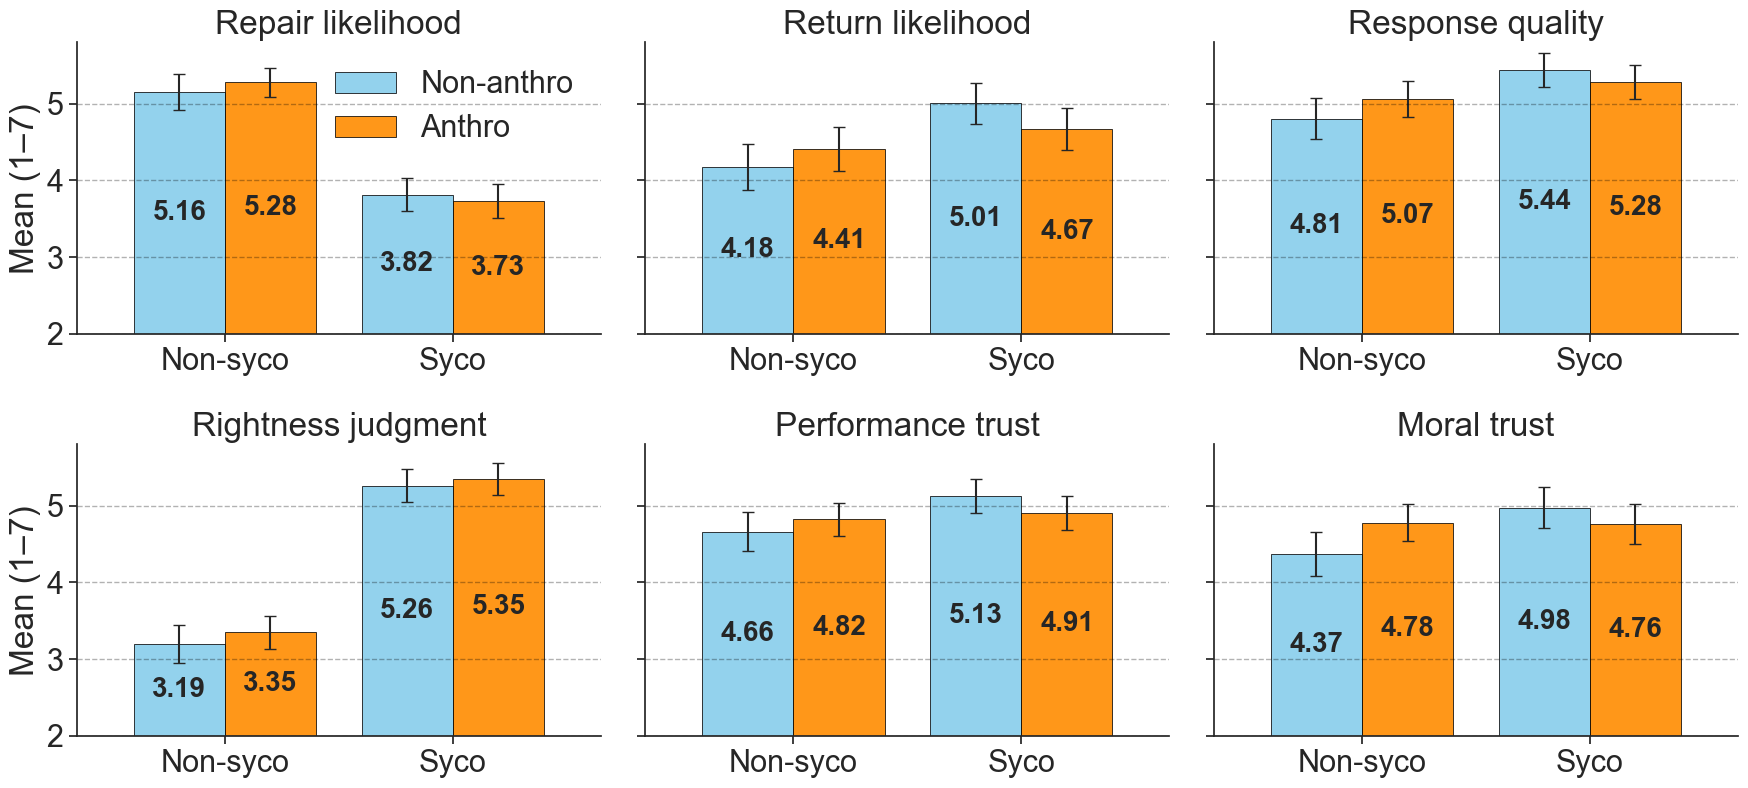

In [35]:
# --- imports & style ---
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Expect: DataFrame `filtered_df` with cols:
# is_syco (0/1), is_anthro (0/1), and the six DVs on a 1–7 scale.

sns.set_context("paper")
sns.set(font_scale=2.0)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
})
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})

def apply_style(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for yy in np.arange(2, 6, 1):
        ax.axhline(y=yy, linestyle='--', color='black', linewidth=1, alpha=0.3)

def annotate_bar_means(ax, decimals=2, fontsize=11):
    """Write the mean on each bar, centered within the *visible* bar region."""
    y0, y1 = ax.get_ylim()
    for rect in ax.patches:
        h = rect.get_height()
        if not np.isfinite(h):
            continue
        x = rect.get_x() + rect.get_width() / 2
        # place text midway between axis bottom (y0) and bar top (h), so it's visible and inside the bar
        y = (h + max(y0, rect.get_y())) / 2
        ax.text(x, y, f"{h:.{decimals}f}",
                ha="center", va="center", fontsize=fontsize, fontweight="bold")

# --- inputs ---
df_source = filtered_df  # change if your DataFrame name differs

target_vals = [
    'repair_score',
    'return_likelihood',
    'response_quality',
    'rightorwrong',
    'performance_trust_score',
    'moral_trust_score',
]

label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}

# --- layout ---
num_vars = len(target_vals)
cols = 3
rows = math.ceil(num_vars / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4.2 * rows), sharey=True)
axes = axes.flatten()

colors = ["skyblue", "darkorange"]  # Non-anthro, Anthro

# --- plotting loop ---
for i, t in enumerate(target_vals):
    df_plot = df_source.dropna(subset=[t, 'is_syco', 'is_anthro'])

    grouped = df_plot.groupby(['is_syco', 'is_anthro'])[t]
    means  = grouped.mean().unstack().reindex(columns=[0, 1]).reindex(index=[0, 1])
    stds   = grouped.std().unstack().reindex(columns=[0, 1]).reindex(index=[0, 1])
    ns     = grouped.count().unstack().reindex(columns=[0, 1]).reindex(index=[0, 1])
    errors = stds / np.sqrt(ns)

    ax = axes[i]
    means.plot.bar(
        yerr=1.96 * errors,
        capsize=4,
        ax=ax,
        alpha=0.9,
        color=colors,
        width=0.8,
        edgecolor="black",
        linewidth=0.6
    )

    ax.set_title(label_map[t])
    ax.set_ylabel("Mean (1–7)")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Non-syco', 'Syco'], rotation=0)
    ax.set_xlabel('')
    ax.set_ylim(2, 5.8)  # headroom for errors/labels
    apply_style(ax)

    # annotate the bar means
    annotate_bar_means(ax, decimals=2,fontsize=20)

    # legend only once
    if i != 0:
        leg = ax.get_legend()
        if leg: leg.remove()
#     else:
#         ax.legend(labels=["Non-anthro", "Anthro"], ncol=1, frameon=False, title="Anthropomorphism")

    if i == 0:
        # grab the auto-created handles/labels (these reflect the actual bar colors)
        h, lbls = ax.get_legend_handles_labels()
        # remap numeric column names to friendly labels
        rename = {'0': 'Non-anthro', '1': 'Anthro', 0: 'Non-anthro', 1: 'Anthro'}
        shared_handles = h
        shared_labels  = [rename.get(lbl, lbl) for lbl in lbls]

        # remove per-axes legend to avoid duplicates
        leg = ax.get_legend()
        if leg:
            leg.remove()

        # place a single shared legend with the original colors from the first axes' legend
        if shared_handles and shared_labels:
            ax.legend(shared_handles, shared_labels,
                       loc='upper right',# bbox_to_anchor=(0.5, 1.02),
                       ncol=1, frameon=False)#, title="Anthropomorphism")

    
# remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("figure_bar_means.pdf", bbox_inches="tight")
plt.savefig("figure_bar_means.png", dpi=300, bbox_inches="tight")
plt.show()


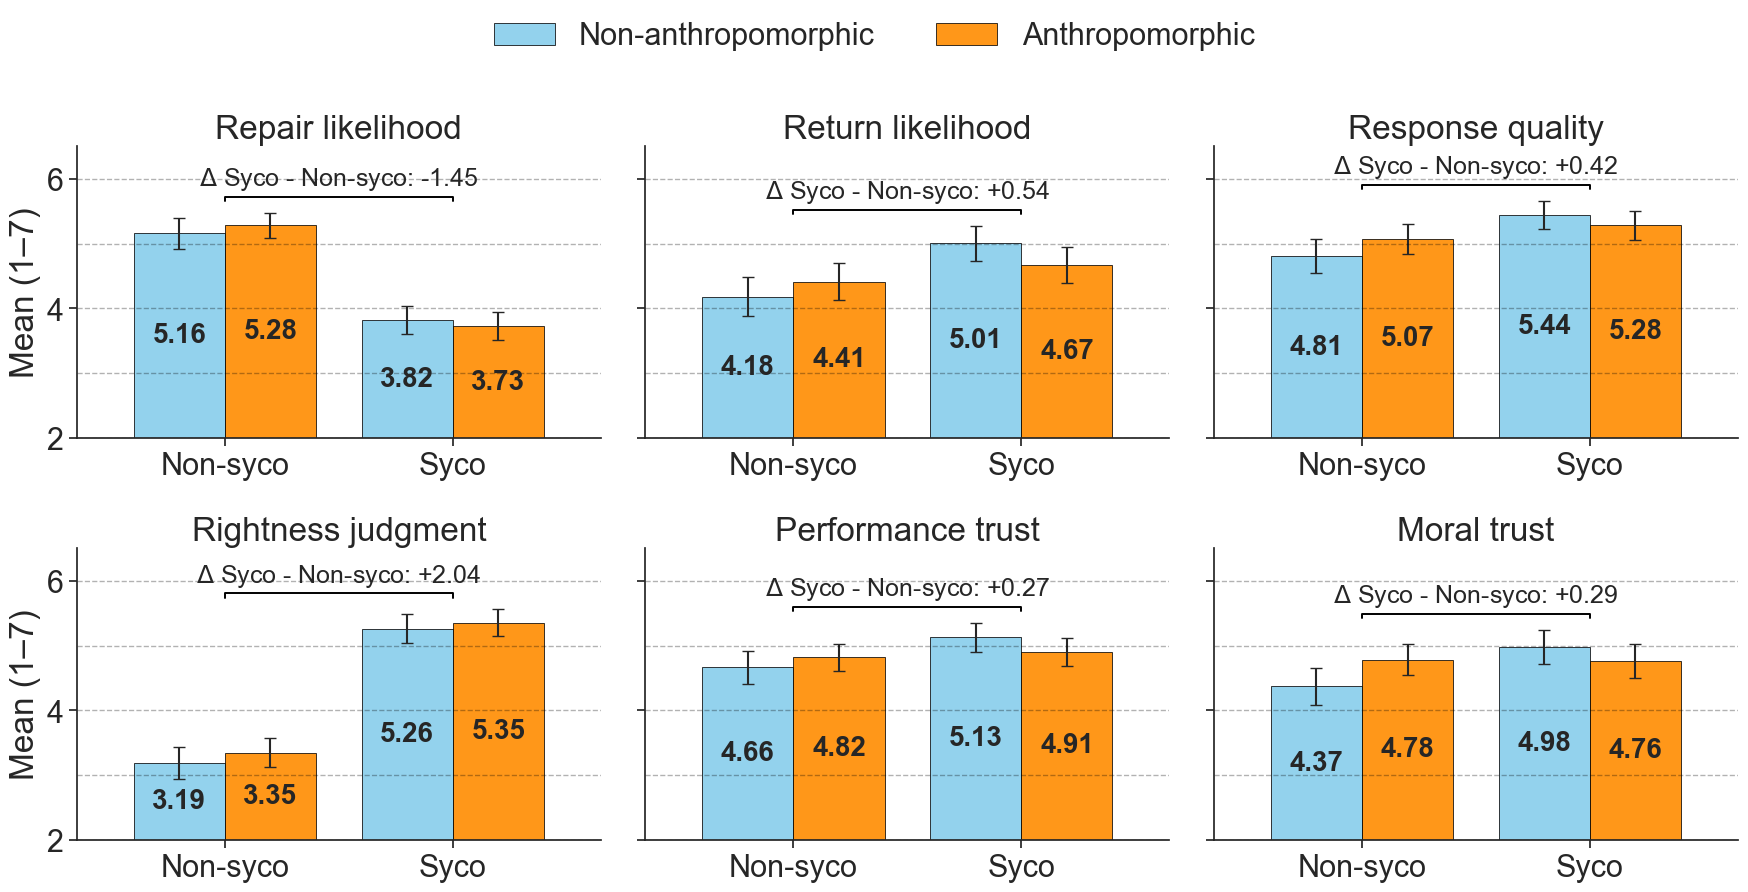

In [34]:
# --- imports & style ---
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Expect: DataFrame `filtered_df` with cols:
# is_syco (0/1), is_anthro (0/1), and the six DVs on a 1–7 scale.

sns.set_context("paper")
sns.set(font_scale=2.0)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
})
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})

def apply_style(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for yy in np.arange(2, 7, 1):
        ax.axhline(y=yy, linestyle='--', color='black', linewidth=1, alpha=0.3)

def annotate_bar_means(ax, decimals=2, fontsize=11):
    """Write the mean on each bar, centered within the *visible* bar region."""
    y0, _ = ax.get_ylim()
    for rect in ax.patches:
        h = rect.get_height()
        if not np.isfinite(h):
            continue
        x = rect.get_x() + rect.get_width() / 2
        y = (h + max(y0, rect.get_y())) / 2
        ax.text(x, y, f"{h:.{decimals}f}",
                ha="center", va="center", fontsize=fontsize, fontweight="bold")

def effect_and_ci(m1, s1, n1, m0, s0, n0):
    """Return diff = m1 - m0 and 95% CI (Welch SE)."""
    diff = m1 - m0
    se_diff = np.sqrt((s1**2)/n1 + (s0**2)/n0)
    ci = 1.96 * se_diff
    return diff, diff - ci, diff + ci

def add_cluster_bracket(ax, x_left, x_right, y_top, text,
                        base_pad=0.04, tick=0.015, lw=1.4, fs=12):
    """
    Draw a bracket spanning two *cluster centers* on the x-axis (e.g., Non-syco vs Syco).
    x_left/x_right are the x positions of the two cluster centers (e.g., 0 and 1).
    y_top is the tallest data height (e.g., max bar+error) across both clusters.
    """
    y0, y1 = ax.get_ylim()
    yr = y1 - y0
    h = y_top + base_pad * yr
    v = h + tick * yr

    # bracket
    ax.plot([x_left, x_left, x_right, x_right], [h, v, v, h],
            c="black", lw=lw, zorder=4, clip_on=False)
    # label with a white box
    ax.text((x_left + x_right) / 2, v + tick * yr, text,
            ha="center", va="bottom", fontsize=18,
            bbox=dict(boxstyle='round,pad=0.2', fc='none', ec='none', alpha=0.95),
            zorder=5, clip_on=False)

# --- inputs ---
df_source = filtered_df  # change if your DataFrame name differs

target_vals = [
    'repair_score',
    'return_likelihood',
    'response_quality',
    'rightorwrong',
    'performance_trust_score',
    'moral_trust_score',
]

label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}

# --- layout ---
num_vars = len(target_vals)
cols = 3
rows = math.ceil(num_vars / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4.2 * rows), sharey=True)
axes = axes.flatten()

colors = ["skyblue", "darkorange"]  # Non-anthro, Anthro
shared_handles = None
shared_labels  = None

# --- plotting loop ---
for i, t in enumerate(target_vals):
    df_plot = df_source.dropna(subset=[t, 'is_syco', 'is_anthro'])

    grouped = df_plot.groupby(['is_syco', 'is_anthro'])[t]
    means  = grouped.mean().unstack().reindex(columns=[0, 1]).reindex(index=[0, 1])
    stds   = grouped.std().unstack().reindex(columns=[0, 1]).reindex(index=[0, 1])
    ns     = grouped.count().unstack().reindex(columns=[0, 1]).reindex(index=[0, 1])
    errors = stds / np.sqrt(ns)

    ax = axes[i]
    means.plot.bar(
        yerr=1.96 * errors,
        capsize=4,
        ax=ax,
        alpha=0.9,
        color=colors,
        width=0.8,
        edgecolor="black",
        linewidth=0.6
    )

    ax.set_title(label_map[t])
    ax.set_ylabel("Mean (1–7)")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Non-syco', 'Syco'], rotation=0)
    ax.set_xlabel('')

    # give enough headroom for the bracket above bars+errors (clamped to <=7.2)
    bar_tops = (means + 1.96 * errors).values
    top_est = np.nanmax(bar_tops)
    upper = max(6.5, min(7.2, top_est + 0.35))
    ax.set_ylim(2, upper)

    apply_style(ax)
    annotate_bar_means(ax, decimals=2, fontsize=20)

    # ----- draw ONE overall (collapsed over anthro) bracket between clusters -----
    overall = df_plot.groupby('is_syco')[t].agg(['mean', 'std', 'count']).reindex([0, 1])
    if overall['count'].min() > 1 and np.isfinite(overall.values).all():
        diff, lo, hi = effect_and_ci(
            overall.loc[1, 'mean'], overall.loc[1, 'std'], overall.loc[1, 'count'],
            overall.loc[0, 'mean'], overall.loc[0, 'std'], overall.loc[0, 'count']
        )
        # cluster centers are exactly at x=0 and x=1 for the two groups
        x_left, x_right = 0, 1
        # use the tallest bar+error across both clusters as the baseline height
        y_top = top_est
        label = f"$\Delta$ Syco - Non-syco: {diff:+.2f}"
        add_cluster_bracket(ax, x_left, x_right, y_top, label)

    # legend only once, using original handles/colors from this axes
    if i == 0:
        h, lbls = ax.get_legend_handles_labels()
        rename = {'0': 'Non-anthropomorphic', '1': 'Anthropomorphic', 0: 'Non-anthropomorphic', 1: 'Anthropomorphic'}
        shared_handles = h
        shared_labels  = [rename.get(lbl, lbl) for lbl in lbls]
        leg = ax.get_legend()
        if leg:
            leg.remove()
#         if shared_handles and shared_labels:
#             ax.legend(shared_handles, shared_labels,
#                       loc='upper right', ncol=1, frameon=False)

    else:
        leg = ax.get_legend()
        if leg: leg.remove()

# # shared legend on top
if shared_handles and shared_labels:
    fig.legend(shared_handles, shared_labels,
               loc='upper center', bbox_to_anchor=(0.5, 1.1),
               ncol=2, frameon=False)

# remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("figure_bar_means_overall_bracket.pdf", bbox_inches="tight")
plt.savefig("figure_bar_means_overall_bracket.png", dpi=300, bbox_inches="tight")
plt.show()


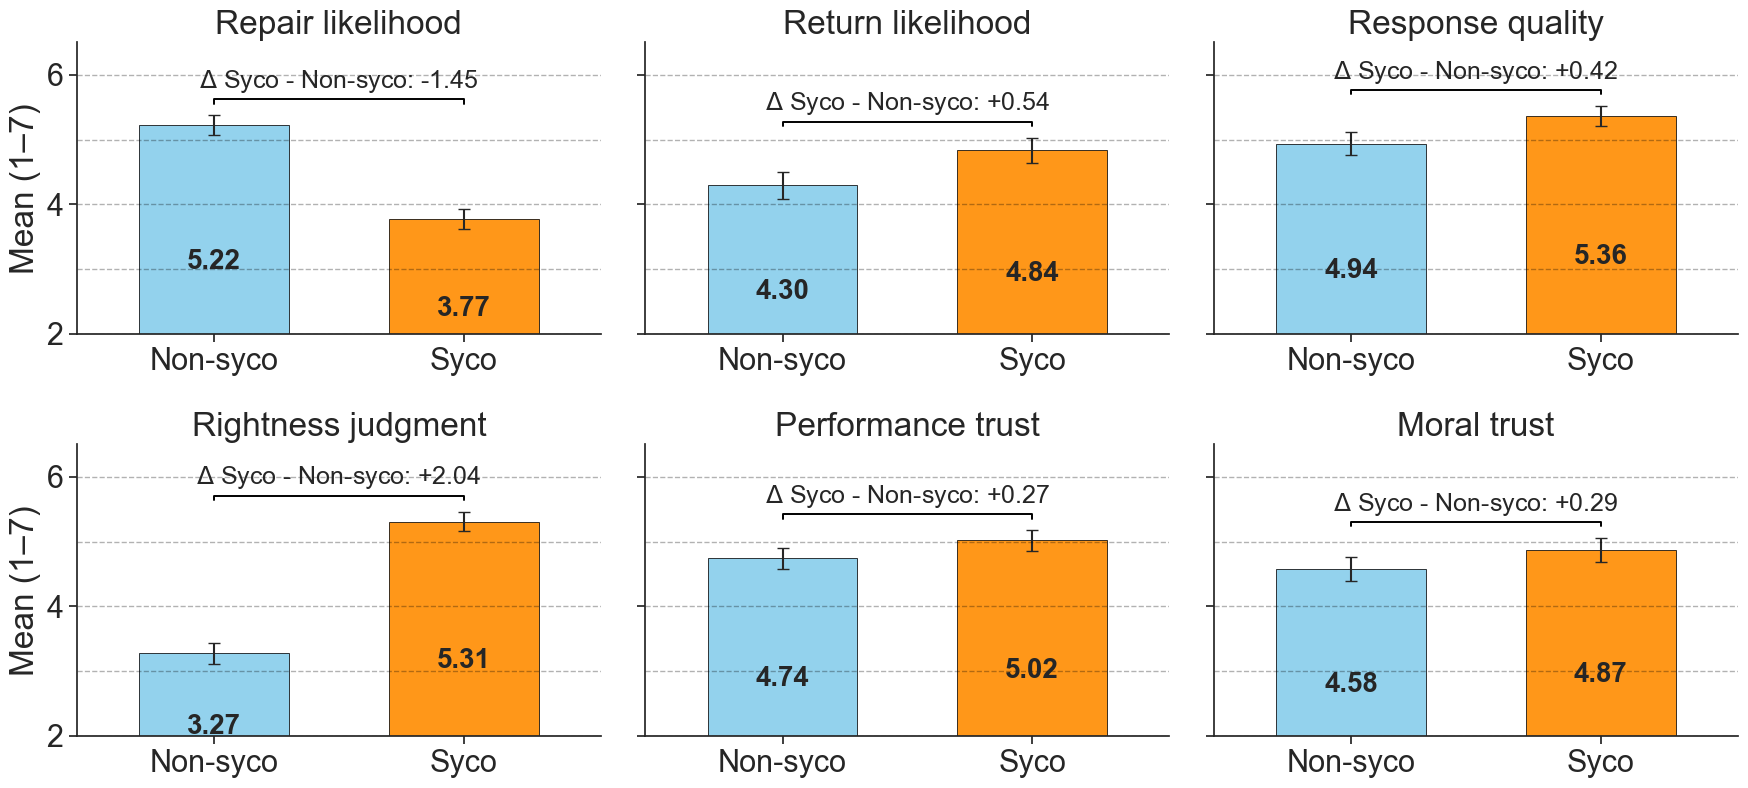

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# --- style ---
sns.set_context("paper")
sns.set(font_scale=2.0)
sns.set_style("white", {"font.family": "sans-serif", "font.serif": ['Helvetica']})
sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})

def apply_style(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for yy in np.arange(2, 7, 1):
        ax.axhline(y=yy, linestyle='--', color='black', linewidth=1, alpha=0.3)

def annotate_bar_means(ax, decimals=2, fontsize=11):
    for rect in ax.patches:
        h = rect.get_height()
        if not np.isfinite(h): continue
        x = rect.get_x() + rect.get_width()/2
        y = rect.get_y() + h/2
        ax.text(x, y+0.5, f"{h:.{decimals}f}",
                ha="center", va="center", fontsize=fontsize, fontweight="bold")

def effect_and_ci(m1, s1, n1, m0, s0, n0):
    diff = m1 - m0
    se_diff = np.sqrt((s1**2)/n1 + (s0**2)/n0)
    ci = 1.96 * se_diff
    return diff, diff - ci, diff + ci

def add_cluster_bracket(ax, x_left, x_right, y_top, text,
                        base_pad=0.04, tick=0.015, lw=1.4, fs=12):
    y0, y1 = ax.get_ylim()
    yr = y1 - y0
    h = y_top + base_pad * yr
    v = h + tick * yr
    ax.plot([x_left, x_left, x_right, x_right], [h, v, v, h],
            c="black", lw=lw, zorder=4, clip_on=False)
    ax.text((x_left + x_right)/2, v + tick*yr, text,
            ha="center", va="bottom", fontsize=18,
            bbox=dict(boxstyle='round,pad=0.2', fc='none', ec='none', alpha=0.95),
            zorder=5, clip_on=False)

# --- inputs ---
df_source = filtered_df  # should already have col is_syco = {0,1}

target_vals = [
    'repair_score',
    'return_likelihood',
    'response_quality',
    'rightorwrong',
    'performance_trust_score',
    'moral_trust_score',
]

label_map = {
    "repair_score": "Repair likelihood",
    "return_likelihood": "Return likelihood",
    "response_quality": "Response quality",
    "rightorwrong": "Rightness judgment",
    "performance_trust_score": "Performance trust",
    "moral_trust_score": "Moral trust",
}

# --- layout ---
num_vars = len(target_vals)
cols = 3
rows = math.ceil(num_vars / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4.2*rows), sharey=True)
axes = axes.flatten()

colors = ["skyblue", "darkorange"]

for i, t in enumerate(target_vals):
    df_plot = df_source.dropna(subset=[t, 'is_syco'])

    grouped = df_plot.groupby('is_syco')[t]
    means  = grouped.mean().reindex([0,1])
    stds   = grouped.std().reindex([0,1])
    ns     = grouped.count().reindex([0,1])
    errors = stds / np.sqrt(ns)

    ax = axes[i]
    means.plot.bar(
        yerr=1.96 * errors,
        capsize=4,
        ax=ax,
        alpha=0.9,
        color=colors,
        width=0.6,
        edgecolor="black",
        linewidth=0.6
    )

    ax.set_title(label_map[t])
    ax.set_ylabel("Mean (1–7)")
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Non-syco', 'Syco'], rotation=0)
    ax.set_xlabel('')

    bar_tops = (means + 1.96 * errors).values
    top_est = np.nanmax(bar_tops)
    upper = max(6.5, min(7.2, top_est + 0.35))
    ax.set_ylim(2, upper)

    apply_style(ax)
    annotate_bar_means(ax, decimals=2, fontsize=20)

    if ns.min() > 1 and np.isfinite(means.values).all():
        diff, lo, hi = effect_and_ci(
            means.loc[1], stds.loc[1], ns.loc[1],
            means.loc[0], stds.loc[0], ns.loc[0]
        )
        add_cluster_bracket(ax, 0, 1, top_est,
                            f"$\Delta$ Syco - Non-syco: {diff:+.2f}")

plt.tight_layout()
plt.savefig("figure_bar_means_syco_study2.pdf", bbox_inches="tight")
plt.savefig("figure_bar_means_syco_study2.png", dpi=300, bbox_inches="tight")
plt.show()


In [39]:
# --- collect summary stats for saving ---
summary_list = []

for i, t in enumerate(target_vals):
    df_plot = df_source.dropna(subset=[t, 'is_syco'])

    grouped = df_plot.groupby('is_syco')[t]
    means  = grouped.mean().reindex([0, 1])
    stds   = grouped.std().reindex([0, 1])
    ns     = grouped.count().reindex([0, 1])
    errors = stds / np.sqrt(ns)

    # append to summary table
    for cond in [0, 1]:  # 0 = Non-syco, 1 = Syco
        summary_list.append({
            "dv": t,
            "label": label_map[t],
            "is_syco": cond,
            "mean": means.loc[cond],
            "std": stds.loc[cond],
            "n": ns.loc[cond],
            "sem": errors.loc[cond],
            "ci95": 1.96 * errors.loc[cond],
            'study':'study2',
        })

# turn into DataFrame
summary_df = pd.DataFrame(summary_list)

# save
summary_df.to_csv("study2_bar_means_summary.csv", index=False)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
sns.set_context("paper")
sns.set(font_scale=1.7)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 1.7
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

sns.set_palette(["skyblue", "darkorange"])
target_vals = [
 'rightorwrong','repair_score',
    
 'response_quality',
 'return_likelihood',
 'performance_trust_score',
 'moral_trust_score',]
# --- load and combine ---
df1 = pd.read_csv("study2_bar_means_summary.csv")
df2 = pd.read_csv("study3_bar_means_summary.csv")
summary_all = pd.concat([df1, df2], ignore_index=True)
summary_all['study'] = summary_all['study'].astype(str)

# Map dv -> human label
label_map = dict(zip(summary_all['dv'], summary_all['label']))

# --- CONFIG ---
# Assumes target_vals already exists and is ordered so the first 2 go in fig1, the rest (4) in fig2
# Example:
# target_vals = ['rightorwrong', 'repair_score', 'return_likelihood', 'response_quality', 'performance_trust_score', 'moral_trust_score']

palette = {0: "skyblue", 1: "darkorange"}  # 0 = Non-syco, 1 = Syco

def plot_chunk(chunk_target_vals, fname, ncols=None):
    n = len(chunk_target_vals)
    if ncols is None:
        # nice defaults: up to 2 cols; fall back to square-ish grid
        ncols = 2 if n <= 2 else 2
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4.2 * nrows), sharey=True)
    if nrows * ncols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, t in enumerate(chunk_target_vals):
        df_plot = summary_all.query("dv == @t")
        ax = axes[i]

        sns.barplot(
            data=df_plot,
            x="study", y="mean", hue="is_syco",
            order=["study2", "study3"],
            hue_order=[0, 1], alpha=0.8,
            palette=palette,
            capsize=0.2, errcolor="black", errwidth=1.5,
            ci=None, ax=ax
        )

        # manual error bars
        for _, row in df_plot.iterrows():
            offset = -0.2 if row['is_syco'] == 0 else 0.2
            ax.errorbar(
                x=(0 if row['study'] == "study2" else 1) + offset,
                y=row['mean'],
                yerr=row['ci95'],
                fmt="none", c="black", capsize=4, lw=1
            )

        # annotate within-study diffs (syco – non-syco)
        # annotate within-study diffs (syco – non-syco)
        diffs = (
            df_plot.pivot(index="study", columns="is_syco", values="mean")
            .assign(
                diff=lambda d: d[1] - d[0],
                pct=lambda d: 100 * (d[1] - d[0]) / d[0]
            )
        )
        for j, (study, row) in enumerate(diffs.iterrows()):
            bar_height = df_plot.query("study==@study")["mean"].max()
            diff_val = row["diff"]
            pct_val = row["pct"]
            x = j  # center of cluster
            y = bar_height + 0.2
            ax.text(
                x, y,
                f"{diff_val:+.2f} ({pct_val:+.0f}%)",
                ha="center", va="bottom", fontweight="bold"
            )
        ax.set_title(label_map.get(t, t))
        ax.set_ylabel("Mean (1–7)")
        ax.set_xlabel('')
        ax.set_xticklabels(["Study 2", "Study 3"])
        ax.set_ylim(2, 6.5)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        for yy in range(2, 7):
            ax.axhline(y=yy, linestyle="--", color="black", alpha=0.3)

        if i != 1:
            ax.get_legend().remove()
        else:
            ax.legend(labels=["Non-syco", "Syco"], ncol=2, frameon=True, loc='lower center')

    # remove any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f"{fname}.pdf", bbox_inches="tight")
    plt.savefig(f"{fname}.png", dpi=300, bbox_inches="tight")
    plt.show()


# --- Make the two figures ---
first_two = target_vals[:2]
last_four = target_vals[2:]

plot_chunk(first_two, fname="clustered_by_study_part1", ncols=2)  # 1 row x 2 cols
plot_chunk(last_four, fname="clustered_by_study_part2", ncols=2)  # 2 rows x 2 cols

